In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
import datetime as dt
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
from matplotlib.animation import FuncAnimation
import sys
from sklearn.model_selection import train_test_split


In [2]:
SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'

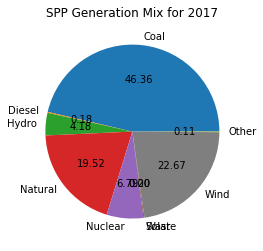

In [3]:
gen_mix = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2017.csv')

new = pd.DataFrame()

first = gen_mix.columns.values.tolist()[1].split(' ')[1]
new[first] = np.array([gen_mix[gen_mix.columns.values.tolist()[1]].sum()])
for element in gen_mix.columns.values.tolist()[2:]:
    if element.split(' ')[1] == first:
        new[first] = new[first] + np.array([gen_mix[element].sum()])
    else:
        new[element.split(' ')[1]] = np.array([gen_mix[element].sum()])
        first = element.split(' ')[1]

output = new.loc[0].values.tolist()[0:-1]
fuels = new.columns.values.tolist()[0:-1]

plt.pie(output,labels=fuels,autopct='%.2f')
plt.title('SPP Generation Mix for 2017')
plt.show()

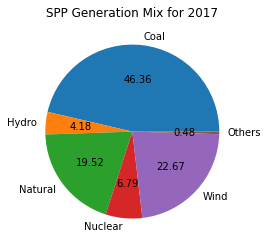

In [4]:
others = []
major_output = []
major_fuels = []
for i in range(len(output)):
    if output[i] < 10e7:
        others.append(output[i])
    else:
        major_output.append(output[i])
        major_fuels.append(fuels[i])
    
major_output.append(np.array(others).sum())
major_fuels.append('Others')

plt.pie(major_output,labels=major_fuels,autopct='%.2f')
plt.title('SPP Generation Mix for 2017')
plt.show()

In [5]:
def GMT2CT(s):
    date = s.split('T')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    time = s.split('T')[1][:-1]
    hour = int(time.split(':')[0])
    if hour >= 6:
        hour = hour - 6
    else:
        hour = 24 + (hour - 6)
        date = date - timedelta(1)
    time = str(hour) + ':' + time.split(':')[1] + ':' + time.split(':')[2]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    return [date, time]


In [6]:
list_intervals = gen_mix[gen_mix.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix['Local Date'] = np.array(local_date)
gen_mix['Local Time'] = np.array(local_time)

In [7]:
gen_mix.head()

GMT MKT Interval   Coal Market   Coal Self   Diesel Fuel Oil   Hydro  \
0  2017-01-01T06:00:00Z        2956.2     13385.3               0.0   251.8   
1  2017-01-01T06:05:00Z        2920.2     13342.3               0.0   241.7   
2  2017-01-01T06:10:00Z        2920.2     13254.2               0.0   241.7   
3  2017-01-01T06:15:00Z        2923.2     13380.3               0.0   267.6   
4  2017-01-01T06:20:00Z        2900.3     13388.1               0.0   276.7   

    Natural Gas   Nuclear   Solar   Waste Disposal Services    Wind  \
0        3025.9    2098.4     0.0                       7.7  4499.1   
1        2988.6    2100.8     0.0                       8.1  4529.3   
2        2969.2    2100.8     0.0                       8.1  4529.3   
3        2981.2    2099.1     0.0                       8.1  4551.8   
4        2960.1    2099.8     0.0                       8.7  4603.1   

    Waste Heat   Other   Average Actual Load  Local Date Local Time  
0          0.0    35.4             25380.548  2017-01-01   00:00:00  
1          0.0    35.7             25356.102  2017-01-01   00:05:00  
2          0.0    35.7             25356.102  2017-01-01   00:10:00  
3          0.0    35.7             25358.945  2017-01-01   00:15:00  
4          0.0    36.4             25345.252  2017-01-01   00:20:00

<ErrorbarContainer object of 3 artists>

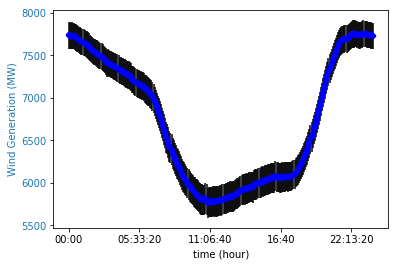

In [8]:
data1 = gen_mix.groupby('Local Time')[[' Wind']].mean()

data1['sem'] = gen_mix.groupby('Local Time')[[' Wind']].sem()

time = data1.index

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (hour)')
ax1.set_ylabel('Wind Generation (MW)', color=color)
ax1.plot(time, data1[' Wind'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.errorbar(time,data1[' Wind'], data1['sem'],
                 marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)

In [9]:
DA = pd.read_csv(r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2017\2017\LMP_SL_2017.csv')
DA.head()

INTERVAL              GMTINTERVALEND  STLMNTLOCNAME  \
0  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000            AEC   
1  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000      AECC_CSWS   
2  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000    AECC_ELKINS   
3  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000  AECC_FITZHUGH   
4  2017-01-01 01:00:00.000000  2017-01-01 07:00:00.000000  AECC_FLTCREEK   

                     PNODENAME      LMP     MLC     MCC      MEC  
0                         SOUC  23.6810  0.2235 -0.0405  23.4980  
1                 CSWS_AECC_LA  24.7412  0.8705  0.3727  23.4980  
2        CSWSELKINSUNELKINS_RA  25.4095  1.1575  0.7541  23.4979  
3             CSWSFITZHUGHPLT1  25.2253  1.0222  0.7052  23.4979  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  24.7430  0.5142  0.7309  23.4979

In [10]:
#DA2 = pd.read_csv(SPP_path + '\\DA\\2017\\2017\\LMP_SL_2017.csv')

    Iterates through every location (more granular, but slower)
DA_intervals = DA[DA.columns[0]].values.tolist()
DA_dates = []
DA_hours = []
for interval in DA_intervals:
    date = interval.split(' ')[0]
    DA_dates.append(dt.datetime.strptime(date,'%Y-%m-%d').date())
    hour = interval.split(' ')[1].split('.')[0]
    DA_hours.append(dt.datetime.strptime(hour,'%H:%M:%S').time())
DA['Local Date'] = np.array(DA_dates)
DA['Local Time'] = np.array(DA_hours)
DA.tail()

In [11]:
# Aggregate locations
DA_aggloc = DA.groupby('GMTINTERVALEND')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                  'LMP':'mean'})
DA_aggloc['loc sem'] = DA.groupby('GMTINTERVALEND')[['LMP']].sem()

In [12]:
DA_intervals = DA_aggloc[DA_aggloc.columns[0]].values.tolist()
DA_dates = []
DA_times = []
weekday = []
for interval in DA_intervals:
    date = interval.split(' ')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    DA_dates.append(date)
    if date.weekday() < 5:
        weekday.append(True)
    else:
        weekday.append(False)
    time = interval.split(' ')[1].split('.')[0]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    DA_times.append(time)
DA_aggloc['Local Date'] = np.array(DA_dates)
DA_aggloc['Local Time'] = np.array(DA_times)
DA_aggloc['Weekday'] = np.array(weekday)
DA_aggloc.tail()

INTERVAL        LMP   loc sem  \
GMTINTERVALEND                                                                
2018-01-01 02:00:00.000000  2017-12-31 20:00:00.000000  44.376063  0.164322   
2018-01-01 03:00:00.000000  2017-12-31 21:00:00.000000  43.884059  0.210470   
2018-01-01 04:00:00.000000  2017-12-31 22:00:00.000000  41.137268  0.174956   
2018-01-01 05:00:00.000000  2017-12-31 23:00:00.000000  43.236809  0.213430   
2018-01-01 06:00:00.000000  2018-01-01 00:00:00.000000  34.699045  0.182230   

                            Local Date Local Time  Weekday  
GMTINTERVALEND                                              
2018-01-01 02:00:00.000000  2017-12-31   20:00:00    False  
2018-01-01 03:00:00.000000  2017-12-31   21:00:00    False  
2018-01-01 04:00:00.000000  2017-12-31   22:00:00    False  
2018-01-01 05:00:00.000000  2017-12-31   23:00:00    False  
2018-01-01 06:00:00.000000  2018-01-01   00:00:00     True

<ErrorbarContainer object of 3 artists>

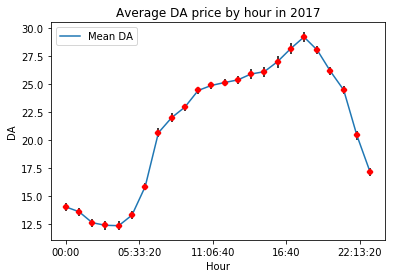

In [13]:
DA_price = DA_aggloc.groupby('Local Time')[['LMP']].mean()
DA_price['time sem'] = DA_aggloc.groupby('Local Time')[['LMP']].sem()
time_x = DA_price.index

plt.plot(time_x,DA_price['LMP'],label='Mean DA')
plt.xlabel('Hour')
plt.ylabel('DA')
plt.title('Average DA price by hour in 2017')
plt.legend(loc='best')
plt.errorbar(time_x,DA_price['LMP'], DA_price['time sem'],
             marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4)


In [14]:
def plot_dfs(df1, df2):
    
    data1 = df1.groupby('Local Time')[[' Wind']].mean()
    data2 = df2.groupby('Local Time')[['LMP']].mean()

    data1['sem'] = df1.groupby('Local Time')[[' Wind']].sem()
    data2['sem'] = df2.groupby('Local Time')[['LMP']].sem()

    time = data1.index

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (hour)')
    ax1.set_ylabel('Wind Generation (MW)', color=color)
    ax1.plot(time, data1[' Wind'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.errorbar(time,data1[' Wind'], data1['sem'],
                     marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4, label=None)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    time = data2.index
    
    color = 'tab:blue'
    ax2.set_ylabel('Price ($/MW)', color=color)  # we already handled the x-label with ax1
    ax2.plot(time, data2['LMP'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.errorbar(time,data2['LMP'], data2['sem'],
                     marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

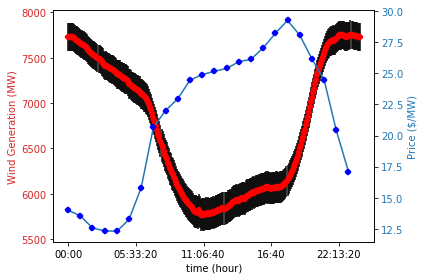

In [15]:
plot_dfs(gen_mix, DA_price)

In [16]:
def plot_dfs_seasons(gen, price, year):
    
    equinox1 = dt.datetime.strptime(year+'-03-21','%Y-%m-%d').date()
    solstice1 = dt.datetime.strptime(year+'-06-21','%Y-%m-%d').date()
    equinox2 = dt.datetime.strptime(year+'-09-21','%Y-%m-%d').date()
    solstice2 = dt.datetime.strptime(year+'-12-21','%Y-%m-%d').date()
    
    winter_price = price[(price['Local Date']<=equinox1)]
    spring_price = price[(price['Local Date']>=equinox1) & (price['Local Date']<=solstice1)]
    summer_price = price[(price['Local Date']>=solstice1) & (price['Local Date']<=equinox2)]
    fall_price = price[(price['Local Date']>=equinox2)]

    winter_gen = gen[(gen['Local Date']<=equinox1)]
    spring_gen = gen[(gen['Local Date']>=equinox1) & (gen['Local Date']<=solstice1)]
    summer_gen = gen[(gen['Local Date']>=solstice1) & (gen['Local Date']<=equinox2)]
    fall_gen = gen[(gen['Local Date']>=equinox2)]

    seasons_dict = {'Winter':[winter_price, winter_gen],
                    'Spring':[spring_price, spring_gen],
                    'Summer':[summer_price, summer_gen],
                    'Fall':[fall_price, fall_gen]
                   }

    for season, data in seasons_dict.items():

        data1 = data[1].groupby('Local Time')[[' Wind']].mean()
        data2 = data[0].groupby('Local Time')[['LMP']].mean()

        time = data1.index
        
        data1['sem'] = gen.groupby('Local Time')[[' Wind']].sem()
        data2['sem'] = price.groupby('Local Time')[['LMP']].sem()

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('time (hour)')
        ax1.set_ylabel('Wind Generation (MW)', color=color)
        ax1.plot(time, data1[' Wind'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.errorbar(time,data1[' Wind'], data1['sem'],
                         marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4, label=None)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        time = data2.index
        
        color = 'tab:blue'
        ax2.set_ylabel('Price ($/MW)', color=color)  # we already handled the x-label with ax1
        ax2.plot(time, data2['LMP'], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.errorbar(time,data2['LMP'], data2['sem'],
                         marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)


        plt.title(season)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

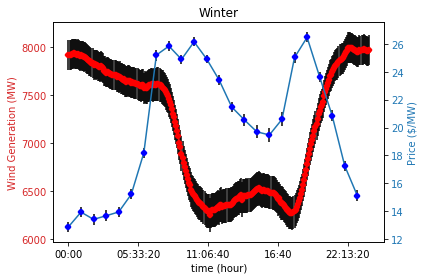

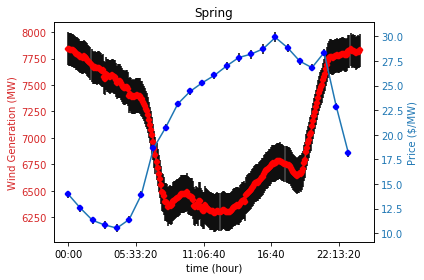

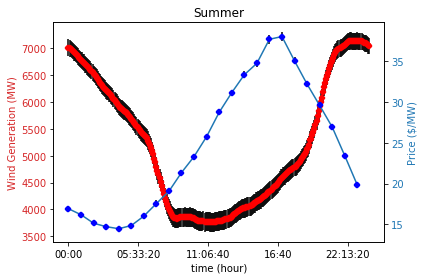

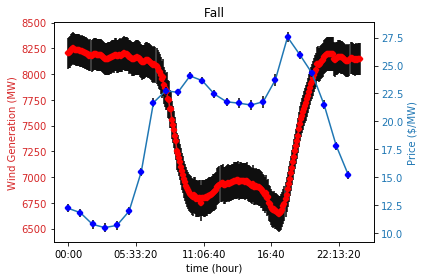

In [17]:
plot_dfs_seasons(gen_mix, DA_aggloc, '2017')

In [18]:
timespan = [str(d) for d in DA_price.index.values.tolist()]
minutes = []
for t in timespan:
    minutes.append(int(t.split(':')[0])*60)
DA_price['Minutes'] = np.array(minutes)
DA_price.head()

LMP  time sem  Minutes
Local Time                              
00:00:00    14.004104  0.360668        0
01:00:00    13.572501  0.361794       60
02:00:00    12.587807  0.373007      120
03:00:00    12.354799  0.379655      180
04:00:00    12.323302  0.381407      240

In [19]:
dict_ssr = {}

for i in range(24):
    try:
        x_avg = (DA_price['Minutes'][i]+DA_price['Minutes'][i+1])/2
        y_avg1 = DA_price['LMP'][0:i+1].values.mean()
        y_avg2 = DA_price['LMP'][i:].values.mean()
        ssr = ((DA_price['LMP'][0:i+1].values - y_avg1)**2).sum() + ((DA_price['LMP'][i:].values - y_avg2)**2).sum()
        dict_ssr[i] = ssr
    except:
        y_avg1 = DA_price['LMP'].values.mean()
        ssr = ((DA_price['LMP'][0:i+1].values - y_avg1)**2).sum()
        dict_ssr[i] = ssr
        
ssr_min = np.array(list(dict_ssr.values())).min()
#np.where(np.array(list(dict_ssr.values()))==ssr_min,1,0).loc

In [20]:
smallest_x = 0
smallest_y = 0
for i in range(24):
    try:
        y_avg1 = DA_price['LMP'][0:i+1].values.mean()
        y_avg2 = DA_price['LMP'][i:].values.mean()
        ssr = ((DA_price['LMP'][0:i+1].values - y_avg1)**2).sum() + ((DA_price['LMP'][i:].values - y_avg2)**2).sum()
        if i == 0:
            smallest_y = ssr
        else:
            if ssr < smallest_y:
                smallest_y = ssr
                smallest_x = i
    except:
        y_avg1 = DA_price['LMP'].values.mean()
        ssr = ((DA_price['LMP'][0:i+1].values - y_avg1)**2).sum()
        if ssr < smallest_y:
                smallest_y = ssr
                smallest_x = i
smallest_x

7

In [21]:
def ssr_split(df):
    smallest_y = 0
    smallest_x = 0
    for i in range(0, df.shape[0]):
        try:
            y_avg1 = df['LMP'][0:i+1].values.mean()
            y_avg2 = df['LMP'][i:df.shape[0]].values.mean()
            ssr = ((df['LMP'][0:i+1].values - y_avg1)**2).sum() + ((df['LMP'][i:df.shape[0]].values - y_avg2)**2).sum()
            if i == 0:
                smallest_y = ssr
            if ssr < smallest_y:
                smallest_y = ssr
                smallest_x = i
        except:
            y_avg1 = df['LMP'].values.mean()
            ssr = ((df['LMP'][0:i+1].values - y_avg1)**2).sum()
            if ssr < smallest_y:
                smallest_y = ssr
                smallest_x = i
    return [df.iloc[0:smallest_x+1],df.iloc[smallest_x+1:]]

In [22]:
split = ssr_split(DA_price)
split[0]

LMP  time sem  Minutes
Local Time                              
00:00:00    14.004104  0.360668        0
01:00:00    13.572501  0.361794       60
02:00:00    12.587807  0.373007      120
03:00:00    12.354799  0.379655      180
04:00:00    12.323302  0.381407      240
05:00:00    13.266328  0.369283      300
06:00:00    15.823157  0.349744      360
07:00:00    20.648623  0.395752      420

In [23]:
def ssr_split(df):
    if df.shape[0]>6:
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df['LMP'][0:i+1].values.mean()
                y_avg2 = df['LMP'][i:df.shape[0]].values.mean()
                ssr = ((df['LMP'][0:i+1].values - y_avg1)**2).sum() + ((df['LMP'][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df['LMP'].values.mean()
                ssr = ((df['LMP'][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        return [df.iloc[0:smallest_x+1],df.iloc[smallest_x+1:]]
    else:
        return df

In [24]:
manual_split = [ssr_split(DA_price)[0]] + ssr_split(ssr_split(ssr_split(DA_price)[1])[0]) + [ssr_split(ssr_split(DA_price)[1])[1]]

In [25]:
for i in range(len(manual_split)):
    print(manual_split[i]['LMP'].mean())


14.322577477209855
24.132254132536573
26.892553924522957
18.758628700759292


In [ ]:
## work on recursive algorithm

#df = DA_price
#splits = []
#while ssr_split(df) != False:
#    splits = ssr_split(df)
#    df = ssr_split(df)[0]
    

In [26]:
# Opening and concatenating DA datasets
days_30 = []
for n in range(1,10):
    days_30.append('0'+str(n))
for n in range(10,31):
    days_30.append(str(n))
days_31 = days_30 + ['31']
cal_dict = {'01':days_31,
           '04':days_30,
           '07':days_31,
           '10':days_31}
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2019'
DA_path = 'DA-LMP-SL-2019'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\'+DA_path+key+value+end))
DA = pd.concat(dfs)
DA.head()

Interval       GMTIntervalEnd Settlement Location  \
0  01/01/2019 01:00:00  01/01/2019 07:00:00                 AEC   
1  01/01/2019 01:00:00  01/01/2019 07:00:00           AECC_CSWS   
2  01/01/2019 01:00:00  01/01/2019 07:00:00         AECC_ELKINS   
3  01/01/2019 01:00:00  01/01/2019 07:00:00       AECC_FITZHUGH   
4  01/01/2019 01:00:00  01/01/2019 07:00:00       AECC_FLTCREEK   

                         Pnode      LMP     MLC     MCC      MEC  
0                         SOUC  19.7410  0.6601  1.8215  17.2594  
1                 CSWS_AECC_LA  21.6101  0.6941  3.6566  17.2594  
2        CSWSELKINSUNELKINS_RA  22.1668  0.4265  4.4809  17.2594  
3             CSWSFITZHUGHPLT1  21.4401  0.9387  3.2420  17.2594  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  21.9882  0.1084  4.6204  17.2594

In [27]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2019'
RT_path = 'RTBM-LMP-DAILY-SL-2019'
end = '.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\'+RT_path+key+value+end))
RT = pd.concat(dfs)
RT.head()

Interval         GMT Interval  Settlement Location Name  \
0  01/01/2019 00:05:00  01/01/2019 06:05:00                       AEC   
1  01/01/2019 00:05:00  01/01/2019 06:05:00                 AECC_CSWS   
2  01/01/2019 00:05:00  01/01/2019 06:05:00               AECC_ELKINS   
3  01/01/2019 00:05:00  01/01/2019 06:05:00             AECC_FITZHUGH   
4  01/01/2019 00:05:00  01/01/2019 06:05:00             AECC_FLTCREEK   

                    PNODE Name      LMP     MLC      MCC     MEC  
0                         SOUC  29.0316  0.1671  25.8830  2.9815  
1                 CSWS_AECC_LA  27.0062  0.1091  23.9156  2.9815  
2        CSWSELKINSUNELKINS_RA  17.4872  0.0613  14.4444  2.9815  
3             CSWSFITZHUGHPLT1  21.9942  0.1735  18.8392  2.9815  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  17.9800  0.0134  14.9851  2.9815

In [28]:
# Groups by interval (hour) and takes mean of locations

DA_aggloc = DA.groupby('GMTIntervalEnd')[['Interval','LMP']].agg({'Interval':'first',
                                                                  'LMP':'mean'})
DA_aggloc['loc sem'] = DA.groupby('GMTIntervalEnd')[['LMP']].sem()

DA_aggloc.head()

Interval        LMP   loc sem
GMTIntervalEnd                                               
01/01/2019 07:00:00  01/01/2019 01:00:00  15.926744  0.209225
01/01/2019 08:00:00  01/01/2019 02:00:00  15.493855  0.206428
01/01/2019 09:00:00  01/01/2019 03:00:00  15.607973  0.198752
01/01/2019 10:00:00  01/01/2019 04:00:00  16.196642  0.161243
01/01/2019 11:00:00  01/01/2019 05:00:00  18.510701  0.118942

In [29]:
# Groups by interval (5-min) and takes mean of locations

RT_aggloc = RT.groupby(' GMT Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                  ' LMP':'mean'})
RT_aggloc['loc sem'] = RT.groupby(' GMT Interval')[[' LMP']].sem()

RT_aggloc.head()

Interval       LMP   loc sem
 GMT Interval                                               
01/01/2019 06:05:00  01/01/2019 00:05:00  0.250149  0.729346
01/01/2019 06:10:00  01/01/2019 00:10:00 -7.802782  0.445401
01/01/2019 06:15:00  01/01/2019 00:15:00  2.905577  0.484422
01/01/2019 06:20:00  01/01/2019 00:20:00  3.350695  0.190441
01/01/2019 06:25:00  01/01/2019 00:25:00 -2.253530  0.353375

In [30]:
comparison = DA_aggloc.join(RT_aggloc,how='right',lsuffix='_DA',rsuffix='_RT')
comparison.head()

Interval_DA  LMP  loc sem_DA          Interval_RT  \
 GMT Interval                                                           
01/01/2019 06:05:00         NaN  NaN         NaN  01/01/2019 00:05:00   
01/01/2019 06:10:00         NaN  NaN         NaN  01/01/2019 00:10:00   
01/01/2019 06:15:00         NaN  NaN         NaN  01/01/2019 00:15:00   
01/01/2019 06:20:00         NaN  NaN         NaN  01/01/2019 00:20:00   
01/01/2019 06:25:00         NaN  NaN         NaN  01/01/2019 00:25:00   

                          LMP  loc sem_RT  
 GMT Interval                              
01/01/2019 06:05:00  0.250149    0.729346  
01/01/2019 06:10:00 -7.802782    0.445401  
01/01/2019 06:15:00  2.905577    0.484422  
01/01/2019 06:20:00  3.350695    0.190441  
01/01/2019 06:25:00 -2.253530    0.353375

In [31]:
comparison = comparison.rename(columns={comparison.columns[1]:'LMP_DA',
                                       comparison.columns[4]:'LMP_RT'})
comparison.head()

Interval_DA  LMP_DA  loc sem_DA          Interval_RT  \
 GMT Interval                                                              
01/01/2019 06:05:00         NaN     NaN         NaN  01/01/2019 00:05:00   
01/01/2019 06:10:00         NaN     NaN         NaN  01/01/2019 00:10:00   
01/01/2019 06:15:00         NaN     NaN         NaN  01/01/2019 00:15:00   
01/01/2019 06:20:00         NaN     NaN         NaN  01/01/2019 00:20:00   
01/01/2019 06:25:00         NaN     NaN         NaN  01/01/2019 00:25:00   

                       LMP_RT  loc sem_RT  
 GMT Interval                              
01/01/2019 06:05:00  0.250149    0.729346  
01/01/2019 06:10:00 -7.802782    0.445401  
01/01/2019 06:15:00  2.905577    0.484422  
01/01/2019 06:20:00  3.350695    0.190441  
01/01/2019 06:25:00 -2.253530    0.353375

In [32]:
# Fills DA blanks and returns new df with less info

def filler_short(df, DA, RT):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    new_df = pd.DataFrame()
    new_df[DA] = np.array(new_list)
    new_df[RT] = df[RT].values
    return new_df

In [33]:
# Fills DA blanks

def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df

In [34]:
filled = filler(comparison, 'LMP_DA')
filled.tail()

Interval_DA     LMP_DA  loc sem_DA  \
 GMT Interval                                                     
11/01/2019 04:40:00                  NaN  15.361160         NaN   
11/01/2019 04:45:00                  NaN  15.361160         NaN   
11/01/2019 04:50:00                  NaN  15.361160         NaN   
11/01/2019 04:55:00                  NaN  15.361160         NaN   
11/01/2019 05:00:00  11/01/2019 00:00:00  13.003898    0.359167   

                             Interval_RT     LMP_RT  loc sem_RT  
 GMT Interval                                                    
11/01/2019 04:40:00  10/31/2019 23:40:00  14.375957    1.003117  
11/01/2019 04:45:00  10/31/2019 23:45:00   9.699994    0.285358  
11/01/2019 04:50:00  10/31/2019 23:50:00   2.202964    0.698098  
11/01/2019 04:55:00  10/31/2019 23:55:00  -2.375167    0.817341  
11/01/2019 05:00:00  11/01/2019 00:00:00  -2.173327    0.786940

In [35]:
filled['loc sem_RT'].mean()

0.3611175471370789

In [36]:
intervals = filled[filled.columns[3]].values.tolist()
dates = []
times = []
weekday = []
for interval in intervals:
    date = interval.split(' ')[0]
    date = dt.datetime.strptime(date,'%m/%d/%Y').date()
    dates.append(date)
    if date.weekday() < 5:
        weekday.append(True)
    else:
        weekday.append(False)
    time = interval.split(' ')[1]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    times.append(time)
filled['Local Date'] = np.array(dates)
filled['Local Time'] = np.array(times)
filled['Weekday'] = np.array(weekday)
filled.tail()

Interval_DA     LMP_DA  loc sem_DA  \
 GMT Interval                                                     
11/01/2019 04:40:00                  NaN  15.361160         NaN   
11/01/2019 04:45:00                  NaN  15.361160         NaN   
11/01/2019 04:50:00                  NaN  15.361160         NaN   
11/01/2019 04:55:00                  NaN  15.361160         NaN   
11/01/2019 05:00:00  11/01/2019 00:00:00  13.003898    0.359167   

                             Interval_RT     LMP_RT  loc sem_RT  Local Date  \
 GMT Interval                                                                 
11/01/2019 04:40:00  10/31/2019 23:40:00  14.375957    1.003117  2019-10-31   
11/01/2019 04:45:00  10/31/2019 23:45:00   9.699994    0.285358  2019-10-31   
11/01/2019 04:50:00  10/31/2019 23:50:00   2.202964    0.698098  2019-10-31   
11/01/2019 04:55:00  10/31/2019 23:55:00  -2.375167    0.817341  2019-10-31   
11/01/2019 05:00:00  11/01/2019 00:00:00  -2.173327    0.786940  2019-11-01   

                    Local Time  Weekday  
 GMT Interval                            
11/01/2019 04:40:00   23:40:00     True  
11/01/2019 04:45:00   23:45:00     True  
11/01/2019 04:50:00   23:50:00     True  
11/01/2019 04:55:00   23:55:00     True  
11/01/2019 05:00:00   00:00:00     True

In [37]:
filled['spread'] = filled['LMP_DA'] - filled['LMP_RT']
filled.tail()

Interval_DA     LMP_DA  loc sem_DA  \
 GMT Interval                                                     
11/01/2019 04:40:00                  NaN  15.361160         NaN   
11/01/2019 04:45:00                  NaN  15.361160         NaN   
11/01/2019 04:50:00                  NaN  15.361160         NaN   
11/01/2019 04:55:00                  NaN  15.361160         NaN   
11/01/2019 05:00:00  11/01/2019 00:00:00  13.003898    0.359167   

                             Interval_RT     LMP_RT  loc sem_RT  Local Date  \
 GMT Interval                                                                 
11/01/2019 04:40:00  10/31/2019 23:40:00  14.375957    1.003117  2019-10-31   
11/01/2019 04:45:00  10/31/2019 23:45:00   9.699994    0.285358  2019-10-31   
11/01/2019 04:50:00  10/31/2019 23:50:00   2.202964    0.698098  2019-10-31   
11/01/2019 04:55:00  10/31/2019 23:55:00  -2.375167    0.817341  2019-10-31   
11/01/2019 05:00:00  11/01/2019 00:00:00  -2.173327    0.786940  2019-11-01   

                    Local Time  Weekday     spread  
 GMT Interval                                       
11/01/2019 04:40:00   23:40:00     True   0.985203  
11/01/2019 04:45:00   23:45:00     True   5.661166  
11/01/2019 04:50:00   23:50:00     True  13.158196  
11/01/2019 04:55:00   23:55:00     True  17.736326  
11/01/2019 05:00:00   00:00:00     True  15.177225

<ErrorbarContainer object of 3 artists>

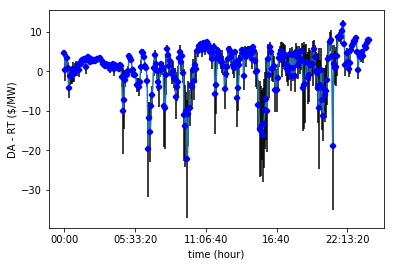

In [38]:
data1 = filled.groupby('Local Time')[['spread']].mean()

time = data1.index

data1['sem'] = filled.groupby('Local Time')[['spread']].sem()

fig, ax1 = plt.subplots()

ax1.set_xlabel('time (hour)')
ax1.set_ylabel('DA - RT ($/MW)')
ax1.plot(time, data1['spread'])
ax1.tick_params(axis='y')
ax1.errorbar(time,data1['spread'], data1['sem'],
                 marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)

In [40]:
abs(filled['spread']).mean()

11.111167871072693

In [41]:
filled = filler(filled, 'loc sem_DA')

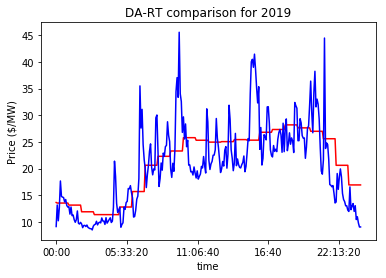

In [42]:
data1 = filled.groupby('Local Time')[['LMP_DA']].mean()
data2 = filled.groupby('Local Time')[['LMP_RT']].mean()

time = data1.index

data1['sem'] = filled.groupby('Local Time')[['LMP_DA']].sem()
data2['sem'] = filled.groupby('Local Time')[['LMP_RT']].sem()

plt.plot(time,data1['LMP_DA'],'red')
plt.plot(time,data2['LMP_RT'],'blue')

plt.ylabel('Price ($/MW)')
plt.title('DA-RT comparison for 2019')
plt.show()

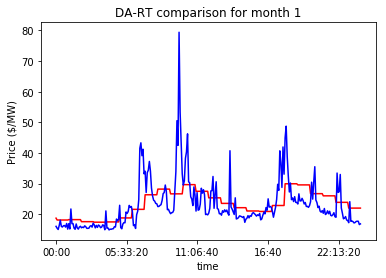

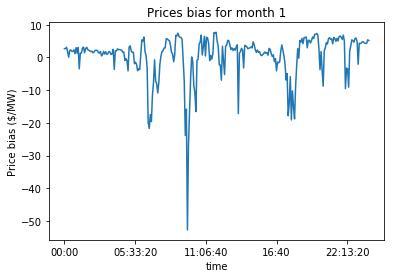

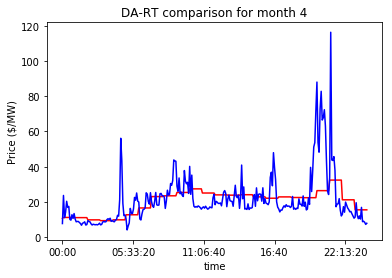

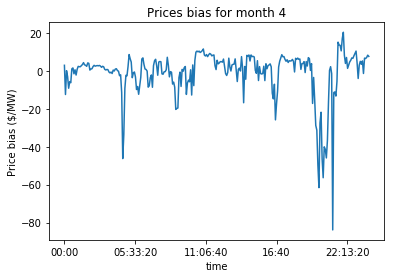

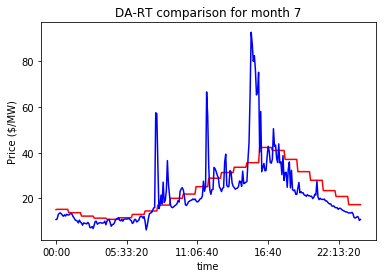

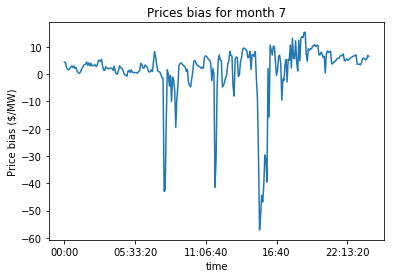

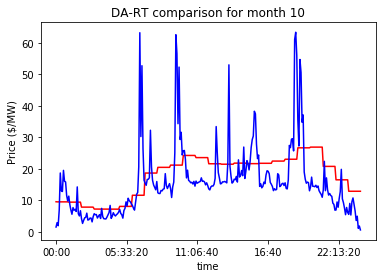

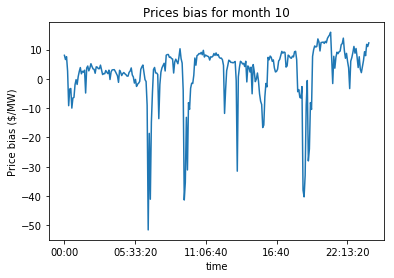

In [43]:
filled_months = filled['Local Date'].values.tolist()
months = []
for month in filled_months:
    months.append(month.month)
filled['Month'] = np.array(months)

for n in [1,4,7,10]:
    by_month = filled[filled['Month']==n]
    data1 = by_month.groupby('Local Time')[['LMP_DA']].mean()
    data2 = by_month.groupby('Local Time')[['LMP_RT']].mean()

    time = data1.index

    data1['sem'] = by_month.groupby('Local Time')[['LMP_DA']].sem()
    data2['sem'] = by_month.groupby('Local Time')[['LMP_RT']].sem()

    fig, ax1 = plt.subplots()
    
    ax1.plot(time,data1['LMP_DA'],'red')
    ax1.plot(time,data2['LMP_RT'],'blue')

    plt.ylabel('Price ($/MW)')
    plt.title('DA-RT comparison for month {}'.format(n))
    plt.show()
    
    fig, ax2 = plt.subplots()
    
    data3 = by_month.groupby('Local Time')[['spread']].mean()
    
    ax2.plot(time,data3['spread'])
    plt.ylabel('Price bias ($/MW)')
    plt.title('Prices bias for month {}'.format(n))
    plt.show()

In [44]:
by_month = filled[filled['Month']==7]
data1 = by_month.groupby('Local Time')[['LMP_DA']].mean()
data2 = by_month.groupby('Local Time')[['LMP_RT']].mean()
peaks = data2.sort_values('LMP_RT',ascending=False)


In [45]:
by_month.sort_values('LMP_RT',ascending=False)

Interval_DA     LMP_DA  loc sem_DA  \
 GMT Interval                                                     
07/12/2019 20:20:00                  NaN  42.988763    0.131599   
07/09/2019 20:35:00                  NaN  39.770369    0.297071   
07/09/2019 20:50:00                  NaN  39.770369    0.297071   
07/01/2019 12:50:00                  NaN  16.328353    0.030428   
07/01/2019 12:55:00                  NaN  16.328353    0.030428   
07/09/2019 20:55:00                  NaN  39.770369    0.297071   
07/12/2019 20:25:00                  NaN  42.988763    0.131599   
07/09/2019 20:40:00                  NaN  39.770369    0.297071   
07/02/2019 16:50:00                  NaN  31.252251    0.083166   
07/09/2019 20:45:00                  NaN  39.770369    0.297071   
07/02/2019 16:55:00                  NaN  31.252251    0.083166   
07/09/2019 20:30:00                  NaN  39.770369    0.297071   
07/09/2019 20:20:00                  NaN  39.770369    0.297071   
07/01/2019 13:00:00  07/01/2019 08:00:00  18.502537    0.042068   
07/08/2019 13:45:00                  NaN  16.883070    0.037743   
07/09/2019 20:25:00                  NaN  39.770369    0.297071   
07/09/2019 21:05:00                  NaN  47.445448    0.403075   
07/09/2019 20:10:00                  NaN  39.770369    0.297071   
07/09/2019 22:05:00                  NaN  47.127266    0.401334   
07/09/2019 20:15:00                  NaN  39.770369    0.297071   
07/27/2019 20:15:00                  NaN  28.950480    0.119204   
07/17/2019 21:05:00                  NaN  46.622029    0.643401   
07/12/2019 20:30:00                  NaN  42.988763    0.131599   
07/09/2019 21:00:00  07/09/2019 16:00:00  47.445448    0.403075   
07/09/2019 22:15:00                  NaN  47.127266    0.401334   
07/09/2019 22:10:00                  NaN  47.127266    0.401334   
07/02/2019 17:00:00  07/02/2019 12:00:00  35.256567    0.093807   
07/07/2019 17:25:00                  NaN  27.131052    0.118932   
07/03/2019 21:40:00                  NaN  35.207637    0.155960   
07/13/2019 22:30:00                  NaN  55.616463    0.098195   
...                                  ...        ...         ...   
07/25/2019 08:35:00                  NaN   4.512103    0.107732   
07/25/2019 08:15:00                  NaN   4.512103    0.107732   
07/25/2019 11:30:00                  NaN   8.958385    0.088705   
07/03/2019 07:35:00                  NaN  14.177434    0.036106   
07/17/2019 07:55:00                  NaN   9.651008    0.196898   
07/25/2019 08:05:00                  NaN   4.512103    0.107732   
07/25/2019 08:20:00                  NaN   4.512103    0.107732   
07/25/2019 08:25:00                  NaN   4.512103    0.107732   
07/25/2019 11:25:00                  NaN   8.958385    0.088705   
07/25/2019 11:20:00                  NaN   8.958385    0.088705   
07/28/2019 12:10:00                  NaN   6.838851    0.124265   
07/25/2019 10:15:00                  NaN   4.249286    0.081920   
07/25/2019 10:40:00                  NaN   4.249286    0.081920   
07/25/2019 08:00:00  07/25/2019 03:00:00   4.512103    0.107732   
07/25/2019 10:00:00  07/25/2019 05:00:00   4.249286    0.081920   
07/28/2019 12:05:00                  NaN   6.838851    0.124265   
07/03/2019 07:15:00                  NaN  14.177434    0.036106   
07/25/2019 10:10:00                  NaN   4.249286    0.081920   
07/18/2019 09:35:00                  NaN   9.113253    0.113017   
07/28/2019 07:05:00                  NaN   6.601524    0.194717   
07/25/2019 10:35:00                  NaN   4.249286    0.081920   
07/27/2019 12:00:00  07/27/2019 07:00:00  10.707167    0.041402   
07/25/2019 10:25:00                  NaN   4.249286    0.081920   
07/26/2019 05:05:00                  NaN   9.110009    0.171052   
07/25/2019 10:20:00                  NaN   4.249286    0.081920   
07/27/2019 12:05:00                  NaN  10.707167    0.041402   
07/25/2019 10:30:00                  NaN   4.249286    0.081920   
07/25/201

In [ ]:
# outliers -- how to deal with them?
# for now, write a function to identify them

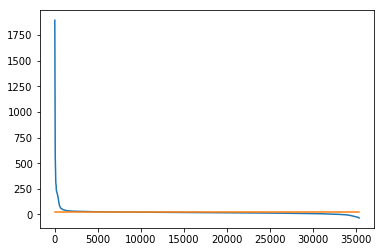

In [46]:
RT_aggloc[' LMP'].mean()
plt.plot(np.arange(1,RT_aggloc.shape[0]+1),RT_aggloc.sort_values(' LMP',ascending=False)[' LMP'])
plt.plot([0.0,float(RT_aggloc.shape[0])],[RT_aggloc[' LMP'].mean(),RT_aggloc[' LMP'].mean()])

In [47]:
(RT_aggloc[RT_aggloc[' LMP']>500].shape[0])/RT_aggloc.shape[0]

0.0017219963866305329

In [48]:
(RT_aggloc[(RT_aggloc[' LMP']<250)&(RT_aggloc[' LMP']>30)].shape[0])/RT_aggloc.shape[0]

0.06868224932249323

In [49]:
RT_peak = filled[filled['LMP_RT']>200].groupby('Local Time')[['LMP_RT']].count()
RT_peak.sort_values('LMP_RT',ascending=False).head()

LMP_RT
Local Time        
20:20:00         7
09:50:00         7
15:15:00         5
20:25:00         5
20:30:00         5

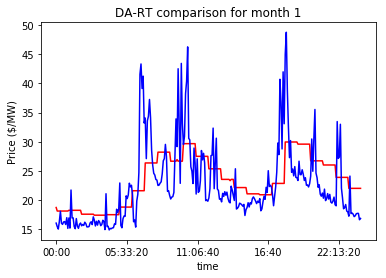

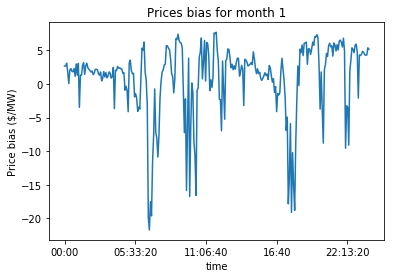

mean spread is 0.8742252898263525


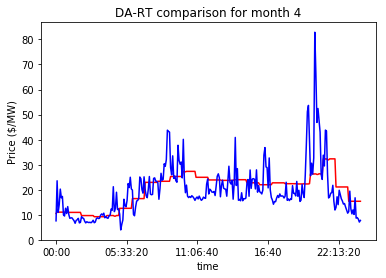

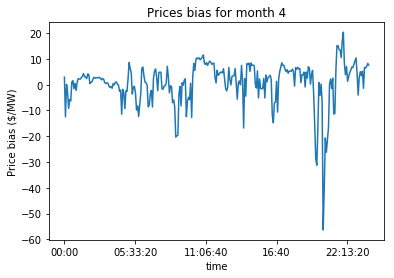

mean spread is 0.6860416804368284


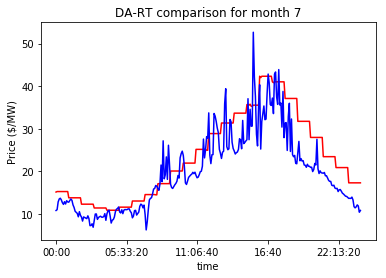

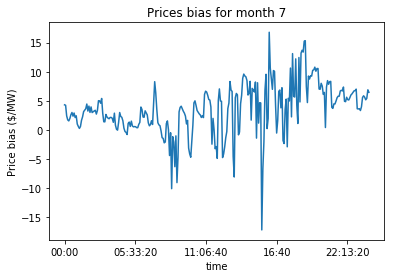

mean spread is 3.591125759561443


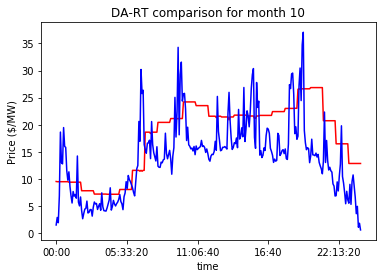

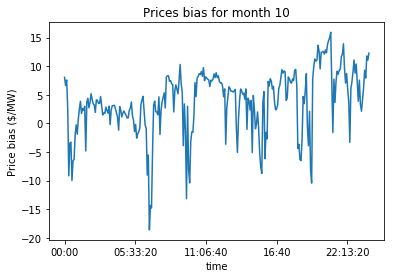

mean spread is 3.8081381841525346


In [50]:
# Deleting outliers for RT > ceiling

filled_months = filled['Local Date'].values.tolist()
months = []
for month in filled_months:
    months.append(month.month)
filled['Month'] = np.array(months)

ceiling = 500

for n in [1,4,7,10]:
    by_month = filled[(filled['Month']==n)&(filled['LMP_RT']<ceiling)]
    data1 = by_month.groupby('Local Time')[['LMP_DA']].mean()
    data2 = by_month.groupby('Local Time')[['LMP_RT']].mean()

    time = data1.index

    data1['sem'] = by_month.groupby('Local Time')[['LMP_DA']].sem()
    data2['sem'] = by_month.groupby('Local Time')[['LMP_RT']].sem()

    fig, ax1 = plt.subplots()
    
    ax1.plot(time,data1['LMP_DA'],'red',label='DA')
    ax1.plot(time,data2['LMP_RT'],'blue',label='RT')

    plt.ylabel('Price ($/MW)')
    plt.title('DA-RT comparison for month {}'.format(n))
    plt.show()
    ax1.legend(loc='best')
    
    fig, ax2 = plt.subplots()
    
    data3 = by_month.groupby('Local Time')[['spread']].mean()
    
    ax2.plot(time,data3['spread'])
    plt.ylabel('Price bias ($/MW)')
    plt.title('Prices bias for month {}'.format(n))
    plt.show()
    print("mean spread is {}".format(data3['spread'].mean()))

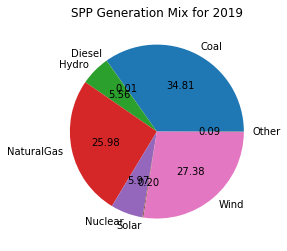

In [51]:
gen_mix_2019 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2019.csv')

new = pd.DataFrame()

first = gen_mix_2019.columns.values.tolist()[1].split(' ')[1]
new[first] = np.array([gen_mix_2019[gen_mix_2019.columns.values.tolist()[1]].sum()])
for element in gen_mix_2019.columns.values.tolist()[2:]:
    if element.split(' ')[1] == first:
        new[first] = new[first] + np.array([gen_mix_2019[element].sum()])
    else:
        new[element.split(' ')[1]] = np.array([gen_mix_2019[element].sum()])
        first = element.split(' ')[1]

output = new.loc[0].values.tolist()[0:-1]
output[3] += output[4]
del output[4]
fuels = new.columns.values.tolist()[0:-1]
fuels[3] += fuels[4]
del fuels[4]
del output[6]
del fuels[6]

plt.pie(output,labels=fuels,autopct='%.2f')
plt.title('SPP Generation Mix for 2019')
plt.show()

In [52]:
list_intervals = gen_mix_2019[gen_mix_2019.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2019['Local Date'] = np.array(local_date)
gen_mix_2019['Local Time'] = np.array(local_time)
gen_mix_2019.head()

GMT MKT Interval   Coal Market   Coal Self   Diesel Fuel Oil Market  \
0  2019-01-01T06:00:00Z         405.9      9523.5                      0.0   
1  2019-01-01T06:05:00Z         401.5      9430.0                      0.0   
2  2019-01-01T06:10:00Z         406.2      9413.6                      0.0   
3  2019-01-01T06:15:00Z         398.7      9305.7                      0.0   
4  2019-01-01T06:20:00Z         394.2      9280.2                      0.0   

    Diesel Fuel Oil Self   Hydro Market   Hydro Self   Natural Gas Market  \
0                    0.0           41.1        577.1               2982.5   
1                    0.0           41.5        578.8               2979.5   
2                    0.0           41.1        577.7               3034.6   
3                    0.0           41.3        579.7               2948.7   
4                    0.0           41.3        578.6               2925.8   

    Gas Self   Nuclear Market     ...       Waste Disposal Services Self  \
0      934.0              0.0     ...                               12.6   
1      899.6              0.0     ...                               12.8   
2      875.5              0.0     ...                               12.9   
3      855.0              0.0     ...                               12.6   
4      854.7              0.0     ...                               12.6   

    Wind Market   Wind Self   Waste Heat Market   Waste Heat Self  \
0           0.0     14228.6                 0.0               0.0   
1           0.0     14215.0                 0.0               0.0   
2           0.0     14109.8                 0.0               0.0   
3           0.0     14220.7                 0.0               0.0   
4           0.0     14237.4                 0.0               0.0   

    Other Market   Other Self       Load  Local Date  Local Time  
0            0.0         33.1  30035.759  2019-01-01    00:00:00  
1            0.0         33.1  29946.144  2019-01-01    00:05:00  
2            0.0         33.5  30011.738  2019-01-01    00:10:00  
3            0.0         33.3  30422.144  2019-01-01    00:15:00  
4            0.0         32.7  30385.553  2019-01-01    00:20:00  

[5 rows x 24 columns]

<ErrorbarContainer object of 3 artists>

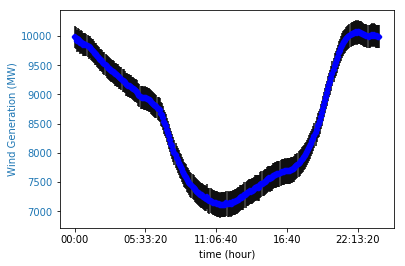

In [53]:
data1 = gen_mix_2019.groupby('Local Time')[[' Wind Self']].mean()

data1['sem'] = gen_mix_2019.groupby('Local Time')[[' Wind Self']].sem()

time = data1.index

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (hour)')
ax1.set_ylabel('Wind Generation (MW)', color=color)
ax1.plot(time, data1[' Wind Self'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.errorbar(time,data1[' Wind Self'], data1['sem'],
                 marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)

In [54]:
gen_mix_2019 = gen_mix_2019.rename(columns={' Wind Self':' Wind'})
filled = filled.rename(columns={'LMP_RT':'LMP'})

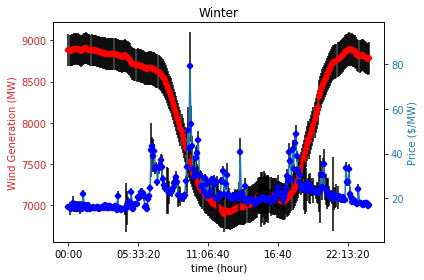

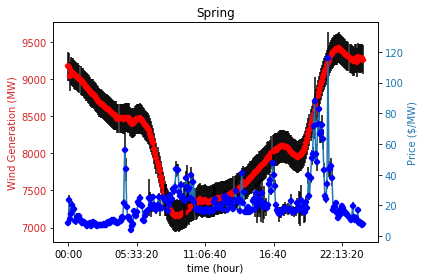

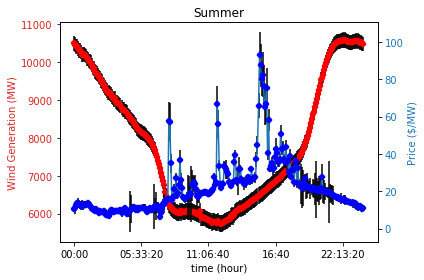

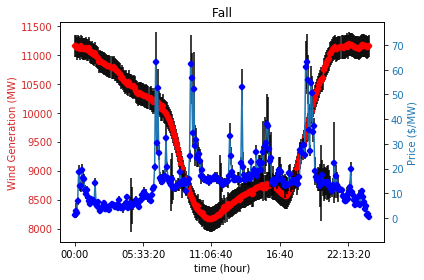

In [55]:
# Wind and RT across seasons
plot_dfs_seasons(gen_mix_2019, filled, '2019')

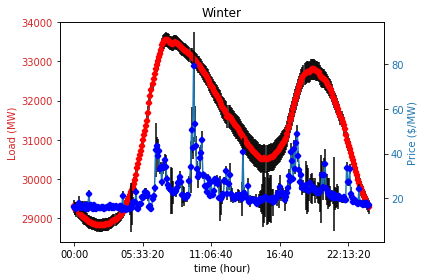

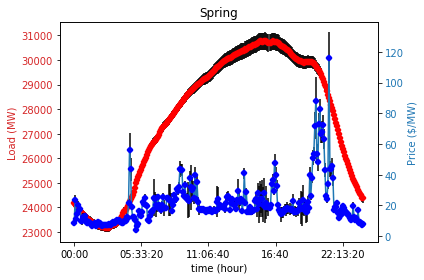

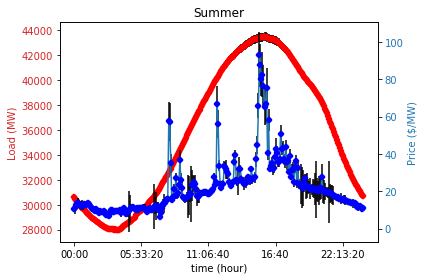

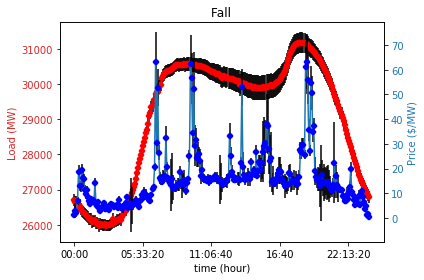

In [56]:
# Total load and RT across seasons

year = '2019'
gen = gen_mix_2019
price = filled

equinox1 = dt.datetime.strptime(year+'-03-21','%Y-%m-%d').date()
solstice1 = dt.datetime.strptime(year+'-06-21','%Y-%m-%d').date()
equinox2 = dt.datetime.strptime(year+'-09-21','%Y-%m-%d').date()
solstice2 = dt.datetime.strptime(year+'-12-21','%Y-%m-%d').date()

winter_price = price[(price['Local Date']<=equinox1)]
spring_price = price[(price['Local Date']>=equinox1) & (price['Local Date']<=solstice1)]
summer_price = price[(price['Local Date']>=solstice1) & (price['Local Date']<=equinox2)]
fall_price = price[(price['Local Date']>=equinox2)]

winter_gen = gen[(gen['Local Date']<=equinox1)]
spring_gen = gen[(gen['Local Date']>=equinox1) & (gen['Local Date']<=solstice1)]
summer_gen = gen[(gen['Local Date']>=solstice1) & (gen['Local Date']<=equinox2)]
fall_gen = gen[(gen['Local Date']>=equinox2)]

seasons_dict = {'Winter':[winter_price, winter_gen],
                'Spring':[spring_price, spring_gen],
                'Summer':[summer_price, summer_gen],
                'Fall':[fall_price, fall_gen]
               }

for season, data in seasons_dict.items():

    data1 = data[1].groupby('Local Time')[[' Load']].mean()
    data2 = data[0].groupby('Local Time')[['LMP']].mean()

    time = data1.index

    data1['sem'] = gen.groupby('Local Time')[[' Load']].sem()
    data2['sem'] = price.groupby('Local Time')[['LMP']].sem()

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (hour)')
    ax1.set_ylabel('Load (MW)', color=color)
    ax1.plot(time, data1[' Load'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.errorbar(time,data1[' Load'], data1['sem'],
                     marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4, label=None)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    time = data2.index

    color = 'tab:blue'
    ax2.set_ylabel('Price ($/MW)', color=color)  # we already handled the x-label with ax1
    ax2.plot(time, data2['LMP'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.errorbar(time,data2['LMP'], data2['sem'],
                     marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)


    plt.title(season)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

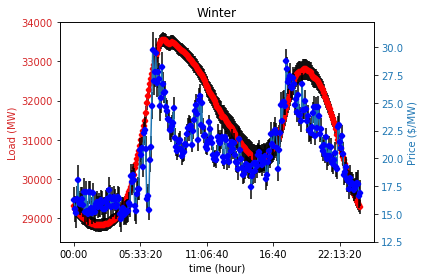

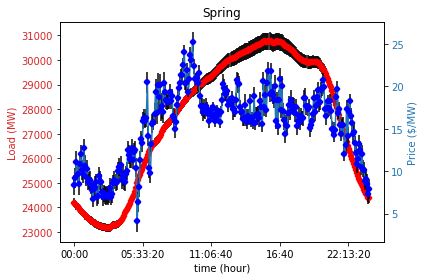

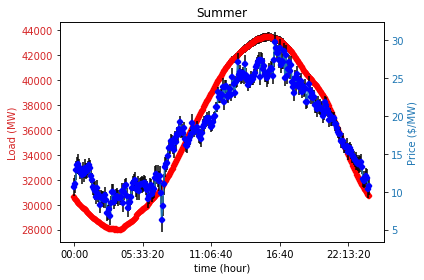

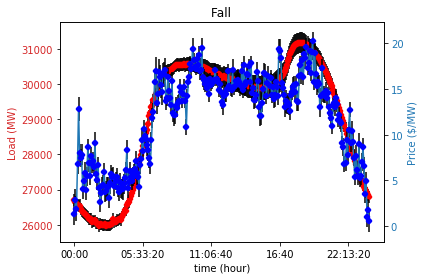

In [57]:
# Total load and RT across seasons -- excluding outliers above ceiling

year = '2019'
gen = gen_mix_2019
price = filled[filled['LMP']<100]

equinox1 = dt.datetime.strptime(year+'-03-21','%Y-%m-%d').date()
solstice1 = dt.datetime.strptime(year+'-06-21','%Y-%m-%d').date()
equinox2 = dt.datetime.strptime(year+'-09-21','%Y-%m-%d').date()
solstice2 = dt.datetime.strptime(year+'-12-21','%Y-%m-%d').date()

winter_price = price[(price['Local Date']<=equinox1)]
spring_price = price[(price['Local Date']>=equinox1) & (price['Local Date']<=solstice1)]
summer_price = price[(price['Local Date']>=solstice1) & (price['Local Date']<=equinox2)]
fall_price = price[(price['Local Date']>=equinox2)]

winter_gen = gen[(gen['Local Date']<=equinox1)]
spring_gen = gen[(gen['Local Date']>=equinox1) & (gen['Local Date']<=solstice1)]
summer_gen = gen[(gen['Local Date']>=solstice1) & (gen['Local Date']<=equinox2)]
fall_gen = gen[(gen['Local Date']>=equinox2)]

seasons_dict = {'Winter':[winter_price, winter_gen],
                'Spring':[spring_price, spring_gen],
                'Summer':[summer_price, summer_gen],
                'Fall':[fall_price, fall_gen]
               }

for season, data in seasons_dict.items():

    data1 = data[1].groupby('Local Time')[[' Load']].mean()
    data2 = data[0].groupby('Local Time')[['LMP']].mean()

    time = data1.index

    data1['sem'] = gen.groupby('Local Time')[[' Load']].sem()
    data2['sem'] = price.groupby('Local Time')[['LMP']].sem()

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (hour)')
    ax1.set_ylabel('Load (MW)', color=color)
    ax1.plot(time, data1[' Load'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.errorbar(time,data1[' Load'], data1['sem'],
                     marker='x', ecolor='black',mec='red', linestyle='None',ms=4, mew=4, label=None)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    time = data2.index

    color = 'tab:blue'
    ax2.set_ylabel('Price ($/MW)', color=color)  # we already handled the x-label with ax1
    ax2.plot(time, data2['LMP'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.errorbar(time,data2['LMP'], data2['sem'],
                     marker='x', ecolor='black',mec='blue', linestyle='None',ms=4, mew=4, label=None)


    plt.title(season)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

1.052803085921596

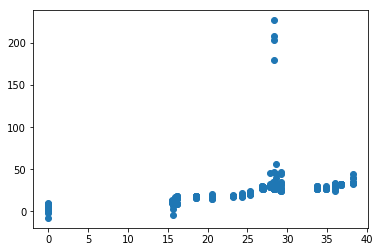

In [58]:
prices_date = filled[filled['Local Date']==filled['Local Date'][0]]
RT_price = prices_date.groupby('Local Time')[['LMP']].first()
DA_price = prices_date.groupby('Local Time')[['LMP_DA']].first()
comparison = DA_price.join(RT_price,how='right',lsuffix='_DA',rsuffix='_RT')
comparison2 = filler(comparison, 'LMP_DA')
m, b = np.polyfit(comparison2['LMP_DA'], comparison2['LMP'], 1)
plt.scatter(comparison2['LMP_DA'],comparison2['LMP'])
m


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


mean ± sem = 0.967 ± 0.087


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  


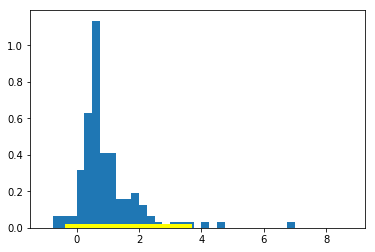

In [59]:
# Histogram with RT vs DA slopes for each day of the year
# for this data set I filled in the empty points for DA

dates_of_year = filled.groupby("Local Date").max().index.values.tolist()

slopes = np.empty(len(dates_of_year))
i = 0
for date in dates_of_year:
    prices_date = filled[filled['Local Date']==date]
    RT_price = prices_date.groupby('Local Time')[['LMP']].first()
    DA_price = prices_date.groupby('Local Time')[['LMP_DA']].first()
    comparison = DA_price.join(RT_price,how='right',lsuffix='_DA',rsuffix='_RT')
    comparison2 = filler(comparison, 'LMP_DA')
    m, b = np.polyfit(comparison2['LMP_DA'], comparison2['LMP'], 1)
    slopes[i] = m
    i += 1

_ = plt.hist(slopes,density=True,bins=np.arange(-1,9,0.25))
mean = slopes.mean()
sem = stats.sem(slopes)
left = np.percentile(slopes, 2.5)
right = np.percentile(slopes, 97.5)
plt.plot([left, right], [0,0], color='yellow', lw=8)
print("mean {} sem = {} {} {}".format(u"\u00B1",round(mean,3),u"\u00B1",round(sem,3)))

In [60]:
# Peaks above 200 for 2019
RT_peak = filled[filled['LMP']>200].groupby('Local Time')[['LMP']].count()
RT_peak.sort_values('LMP',ascending=False).head()

LMP
Local Time     
20:20:00      7
09:50:00      7
15:15:00      5
20:25:00      5
20:30:00      5

In [61]:
# better name
DART = filled

In [62]:
study = DART[DART['Local Date']==dt.date(2019,1,2)]
intervals = study['Local Time'].values.tolist()
i = 0
points = []
for time in intervals:
    mean = study['LMP'][0:i+1].mean()
    if study['LMP'][i] > 2*mean:
        if (study['LMP'][i] - mean) > study['LMP'].mean()/2:
            points.append(time)
    i += 1
points

[datetime.time(10, 10),
 datetime.time(10, 15),
 datetime.time(10, 20),
 datetime.time(10, 35),
 datetime.time(10, 40),
 datetime.time(10, 55),
 datetime.time(12, 15),
 datetime.time(12, 20),
 datetime.time(12, 30),
 datetime.time(12, 35),
 datetime.time(17, 50),
 datetime.time(18, 25),
 datetime.time(18, 45)]

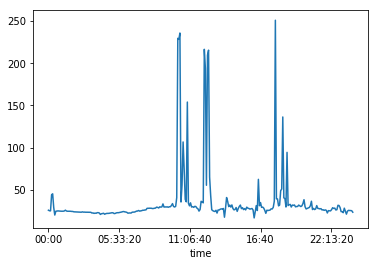

In [63]:
plt.plot(study['Local Time'],study['LMP'])

In [64]:
def crit_pts(df):
    intervals = df['Local Time'].values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP'][0:i+1].mean()
        if df['LMP'][i] > 2*mean:
            if (df['LMP'][i] - mean) > df['LMP'].mean()/2:
                points.append(time)
        i += 1
    return points

In [65]:
study = DART[DART['Local Date']==dt.date(2019,7,10)]
crit_pts(study)

[]

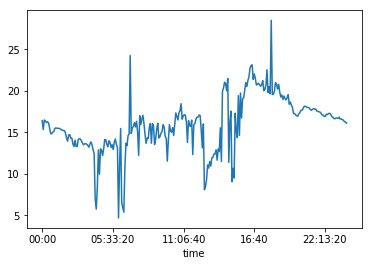

In [66]:
plt.plot(study['Local Time'],study['LMP'])
# there were fluctuations, but this day was particularly "calm" -- no sharp peaks with terrible outliers

In [67]:
study = DART[DART['Local Date']==dt.date(2019,10,11)]
len(crit_pts(study))
# on the other hand, this day was a lot more agitated 

61

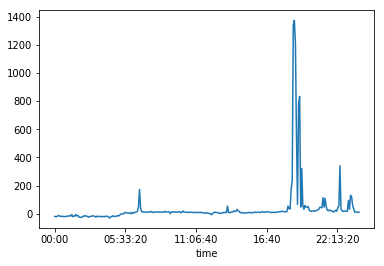

In [68]:
plt.plot(study['Local Time'],study['LMP'])

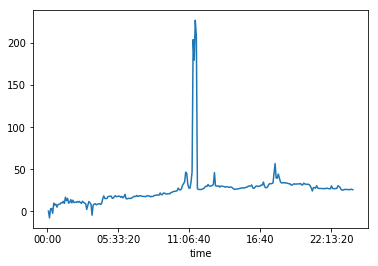

In [69]:
study = DART[DART['Local Date']==dt.date(2019,1,1)]
plt.plot(study['Local Time'],study['LMP'])

In [70]:
crit_pts(study)

[datetime.time(10, 35),
 datetime.time(10, 40),
 datetime.time(10, 45),
 datetime.time(10, 50),
 datetime.time(10, 55),
 datetime.time(11, 0),
 datetime.time(11, 15),
 datetime.time(11, 20),
 datetime.time(11, 25),
 datetime.time(11, 30),
 datetime.time(11, 35),
 datetime.time(11, 40),
 datetime.time(13, 5),
 datetime.time(17, 50)]

In [71]:
DART_days = DART['Local Date'].values.tolist()
days = []
for day in DART_days:
    days.append(day.day)
DART['Day'] = np.array(days)

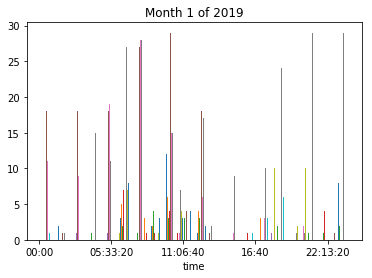

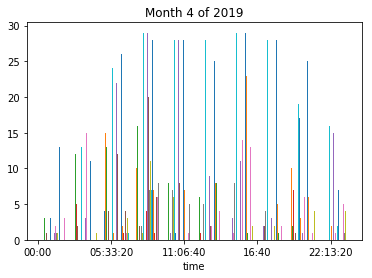

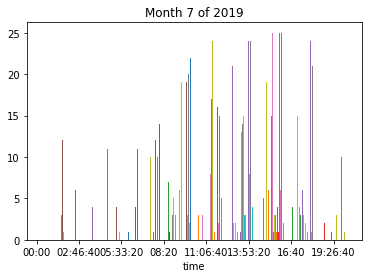

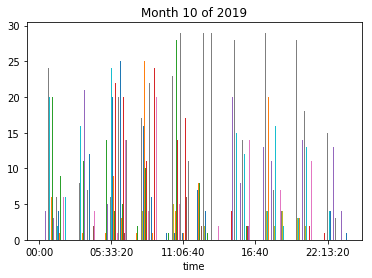

In [72]:
# histogram to visualize most common peak times -- interpretation unclear though
arrays = []
for month in [1,4,7,10]:
    month_df = DART[DART['Month']==month]
    critical = []
    for day in range (1,month_df['Day'][-1]+1):
        day_df = month_df[month_df['Day']==day]
        critical.append(crit_pts(day_df))
    crit_array = np.array(critical)
    arrays.append(crit_array)
    _ = plt.hist(crit_array)
    plt.title("Month {} of 2019".format(month))
    plt.show()
    

In [73]:
# the crit_pts works well for well-defined curves, i.e., positive prices with sharp peaks,
# but not quite well for days with negative prices (Jan 6) and weirder shapes
# for now, use this function for monthly averages

dfs = []
for n in range(1,31):    
    df_day = pd.DataFrame({'hour':arrays[0][n]})
    dfs.append(df_day)

#pd.concat(dfs,axis=1)

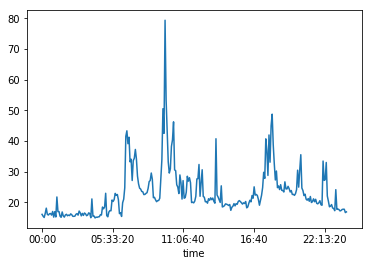

[datetime.time(6, 35), datetime.time(6, 40), datetime.time(6, 45), datetime.time(6, 50), datetime.time(9, 30), datetime.time(9, 35), datetime.time(9, 40), datetime.time(9, 45), datetime.time(10, 20), datetime.time(18, 5)]


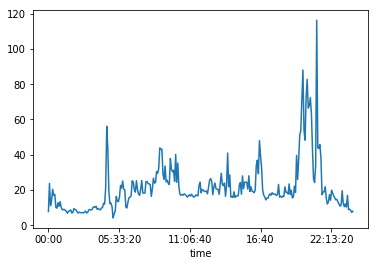

[datetime.time(4, 30), datetime.time(4, 35), datetime.time(4, 40), datetime.time(5, 50), datetime.time(6, 35), datetime.time(8, 30), datetime.time(8, 40), datetime.time(8, 45), datetime.time(8, 50), datetime.time(8, 55), datetime.time(9, 10), datetime.time(9, 35), datetime.time(10, 0), datetime.time(10, 10), datetime.time(14, 5), datetime.time(16, 35), datetime.time(16, 40), datetime.time(19, 30), datetime.time(19, 45), datetime.time(19, 50), datetime.time(19, 55), datetime.time(20, 0), datetime.time(20, 5), datetime.time(20, 10), datetime.time(20, 15), datetime.time(20, 20), datetime.time(20, 25), datetime.time(20, 30), datetime.time(20, 35), datetime.time(20, 40), datetime.time(20, 45), datetime.time(21, 5), datetime.time(21, 20)]


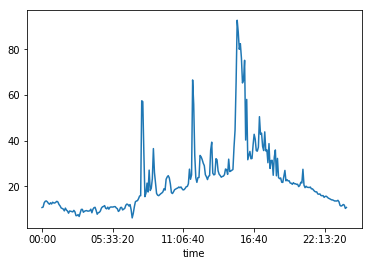

[datetime.time(7, 50), datetime.time(7, 55), datetime.time(8, 0), datetime.time(8, 25), datetime.time(8, 45), datetime.time(8, 50), datetime.time(11, 50), datetime.time(11, 55), datetime.time(12, 0), datetime.time(12, 25), datetime.time(12, 30), datetime.time(12, 35), datetime.time(13, 15), datetime.time(13, 20), datetime.time(15, 5), datetime.time(15, 10), datetime.time(15, 15), datetime.time(15, 20), datetime.time(15, 25), datetime.time(15, 30), datetime.time(15, 35), datetime.time(15, 40), datetime.time(15, 45), datetime.time(15, 50), datetime.time(15, 55), datetime.time(16, 5), datetime.time(17, 5)]


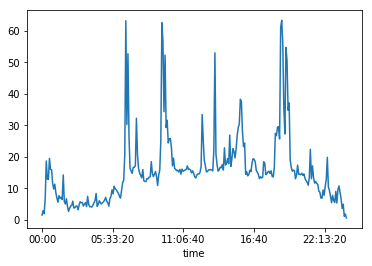

[datetime.time(0, 20), datetime.time(0, 35), datetime.time(6, 30), datetime.time(6, 35), datetime.time(6, 40), datetime.time(6, 45), datetime.time(6, 50), datetime.time(7, 25), datetime.time(7, 30), datetime.time(9, 20), datetime.time(9, 25), datetime.time(9, 30), datetime.time(9, 35), datetime.time(9, 40), datetime.time(9, 45), datetime.time(9, 50), datetime.time(10, 0), datetime.time(10, 5), datetime.time(12, 35), datetime.time(13, 35), datetime.time(15, 30), datetime.time(15, 35), datetime.time(15, 40), datetime.time(18, 45), datetime.time(18, 50), datetime.time(18, 55), datetime.time(19, 0), datetime.time(19, 10), datetime.time(19, 15), datetime.time(19, 20), datetime.time(19, 25)]


In [74]:
monthly_pts = []
for n in [1,4,7,10]:
    by_month = DART[DART['Month']==n]
    data = by_month.groupby('Local Time')[['LMP']].mean()
    data['Local Time'] = data.index
    monthly_pts.append(crit_pts(data))
    plt.plot(data.index, data['LMP'])
    plt.show()
    print(crit_pts(data))


Text(0.5, 1.0, 'peak occurrences in 2019')

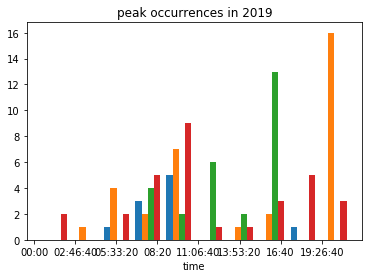

In [75]:
plt.hist(np.array(monthly_pts))
plt.title('peak occurrences in 2019')

In [ ]:
###### let's study 2017

In [76]:
gen_mix_2017 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2017.csv')
list_intervals = gen_mix_2017[gen_mix_2017.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2017['Local Date'] = np.array(local_date)
gen_mix_2017['Local Time'] = np.array(local_time)

In [77]:
RT_2017 = pd.read_csv(SPP_path + '\\RT\\2017\\LMP_SL_2017.csv')
RT_2017

INTERVAL              GMTINTERVALEND  \
0         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
1         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
2         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
3         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
4         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
5         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
6         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
7         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
8         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
9         2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
10        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
11        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
12        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
13        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
14        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
15        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
16        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
17        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
18        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
19        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
20        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
21        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
22        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
23        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
24        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
25        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
26        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
27        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
28        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
29        2017-01-01 00:05:00.000000  2017-01-01 06:05:00.000000   
...                              ...                         ...   
99363078  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363079  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363080  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363081  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363082  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363083  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363084  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363085  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363086  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363087  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363088  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363089  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363090  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363091  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363092  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363093  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363094  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363095  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363096  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363097  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363098  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363099  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363100  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363101  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363102  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363103  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363104  2018-01-01 00:00:00.000000  2018-01-01 06:00:00.000000   
99363105  2018-0

In [78]:
RT2017_aggloc = RT_2017.groupby('INTERVAL')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                    'LMP':'mean'})

In [79]:
def add_info(df):
    intervals = df[df.columns[0]].values.tolist()
    dates = []
    times = []
    weekday = []
    months = []
    days = []
    hour = []
    for interval in intervals:
        date = interval.split(' ')[0]
        try:
            date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        except:
            date = dt.datetime.strptime(date,'%m/%d/%Y').date()            
        dates.append(date)
        months.append(date.month)
        days.append(date.day)
        if date.weekday() < 5:
            weekday.append(True)
        else:
            weekday.append(False)
        time = interval.split(' ')[1].split('.')[0]
        time = dt.datetime.strptime(time,'%H:%M:%S').time()
        times.append(time)
        hour.append(dt.time(time.hour))
    df['Local Date'] = np.array(dates)
    df['Local Time'] = np.array(times)
    df['Hour'] = np.array(hour)
    df['Weekday'] = np.array(weekday)
    df['Month'] = np.array(months)
    df['Day'] = np.array(days)
    return df

In [80]:
RT = add_info(RT2017_aggloc)
RT.head()

INTERVAL        LMP  Local Date  \
INTERVAL                                                                        
2017-01-01 00:05:00.000000  2017-01-01 00:05:00.000000  16.911322  2017-01-01   
2017-01-01 00:10:00.000000  2017-01-01 00:10:00.000000  17.264418  2017-01-01   
2017-01-01 00:15:00.000000  2017-01-01 00:15:00.000000  16.422609  2017-01-01   
2017-01-01 00:20:00.000000  2017-01-01 00:20:00.000000  21.653247  2017-01-01   
2017-01-01 00:25:00.000000  2017-01-01 00:25:00.000000  18.293177  2017-01-01   

                           Local Time      Hour  Weekday  Month  Day  
INTERVAL                                                              
2017-01-01 00:05:00.000000   00:05:00  00:00:00    False      1    1  
2017-01-01 00:10:00.000000   00:10:00  00:00:00    False      1    1  
2017-01-01 00:15:00.000000   00:15:00  00:00:00    False      1    1  
2017-01-01 00:20:00.000000   00:20:00  00:00:00    False      1    1  
2017-01-01 00:25:00.000000   00:25:00  00:00:00    False      1    1

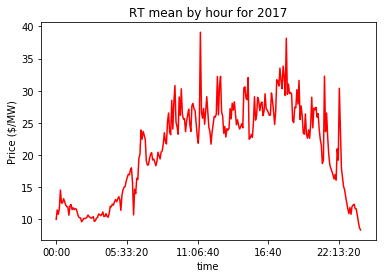

In [81]:
data1 = RT.groupby('Local Time')[['LMP']].mean()

time = data1.index

plt.plot(time,data1['LMP'],'red')

plt.ylabel('Price ($/MW)')
plt.title('RT mean by hour for 2017')
plt.show()

In [82]:
def get_LMP(df, x):
    i = 0
    LMP = []
    for time in df['Local Time']:
        if time in x:
            LMP.append(df['LMP'][i])
        i += 1
    array = np.array(LMP)
    return array

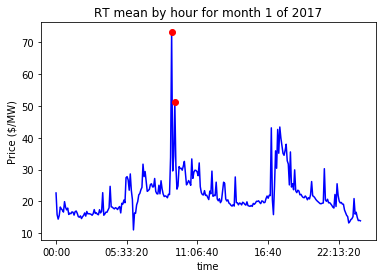

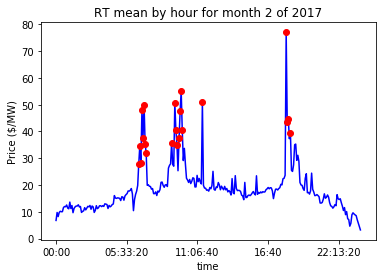

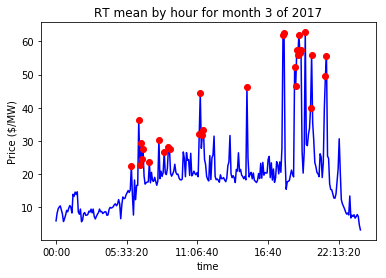

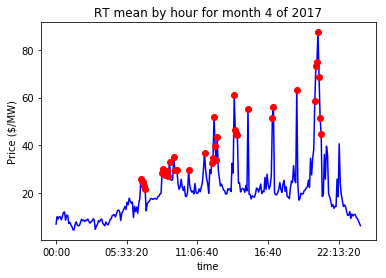

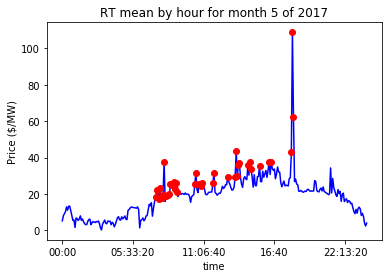

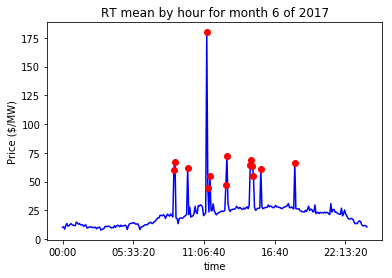

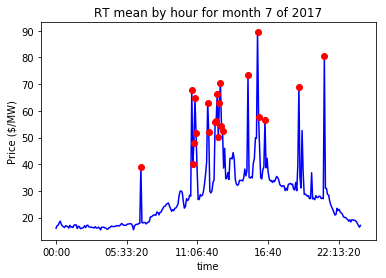

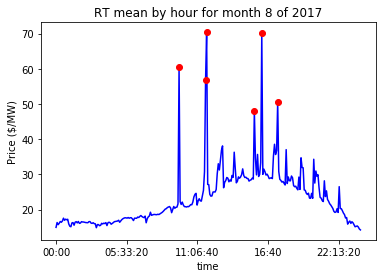

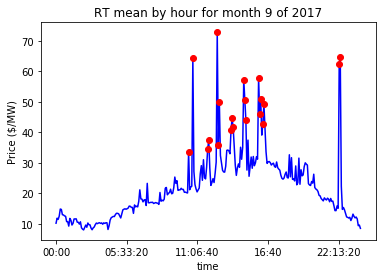

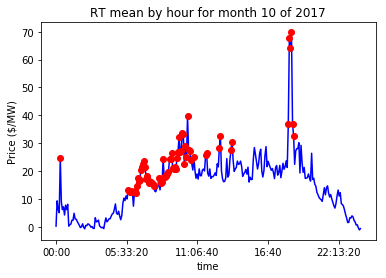

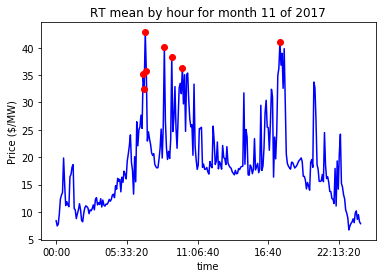

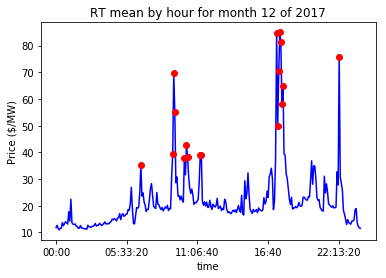

In [83]:

monthly_pts = []
for n in range(1,13):
    by_month = RT[RT['Month']==n]
    data1 = by_month.groupby('Local Time')[['LMP']].mean()
    data1['Local Time'] = data1.index
    
    time = data1.index

    fig, ax1 = plt.subplots()
    
    ax1.plot(time,data1['LMP'],'blue')

    monthly_pts.append(crit_pts(data1))
    
    plt.plot(crit_pts(data1),get_LMP(data1,crit_pts(data1)),'ro')
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2017'.format(n))
    plt.show()

Text(0.5, 1.0, 'peak occurrences in 2017')

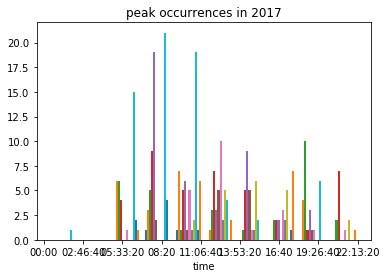

In [84]:
plt.hist(np.array(monthly_pts))
plt.title('peak occurrences in 2017')
# inconclusive

In [ ]:
####### 2018

In [85]:
gen_mix_2018 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2018.csv')
list_intervals = gen_mix_2018[gen_mix_2018.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2018['Local Date'] = np.array(local_date)
gen_mix_2018['Local Time'] = np.array(local_time)

In [86]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))

In [87]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2018'
RT_path = 'RTBM-LMP-DAILY-SL-2018'
end = '.csv'
dfs = []
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+RT_path+key+value+end))
RT = pd.concat(dfs)
RT.head()

Interval         GMT Interval  Settlement Location Name  \
0  01/01/2018 00:05:00  01/01/2018 06:05:00                       AEC   
1  01/01/2018 00:05:00  01/01/2018 06:05:00                 AECC_CSWS   
2  01/01/2018 00:05:00  01/01/2018 06:05:00               AECC_ELKINS   
3  01/01/2018 00:05:00  01/01/2018 06:05:00             AECC_FITZHUGH   
4  01/01/2018 00:05:00  01/01/2018 06:05:00             AECC_FLTCREEK   

                    PNODE Name       LMP     MLC      MCC       MEC  
0                         SOUC  255.8769  5.4654   0.0000  250.4115  
1                 CSWS_AECC_LA  262.5802  5.0312   7.1375  250.4115  
2        CSWSELKINSUNELKINS_RA  270.2234  3.0020  16.8099  250.4115  
3             CSWSFITZHUGHPLT1  257.2724  6.8609   0.0000  250.4115  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  266.5657 -3.0577  19.2119  250.4115

In [88]:
RT2018_aggloc = RT.groupby('Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                    ' LMP':'mean'})

In [89]:
RT2018 = add_info(RT2018_aggloc)
RT2018 = RT2018.rename(columns={' LMP':'LMP'})
RT2018.tail()

Interval       LMP  Local Date Local Time  \
Interval                                                                    
12/31/2018 23:35:00  12/31/2018 23:35:00  4.594098  2018-12-31   23:35:00   
12/31/2018 23:40:00  12/31/2018 23:40:00  5.619686  2018-12-31   23:40:00   
12/31/2018 23:45:00  12/31/2018 23:45:00  6.208854  2018-12-31   23:45:00   
12/31/2018 23:50:00  12/31/2018 23:50:00  6.696047  2018-12-31   23:50:00   
12/31/2018 23:55:00  12/31/2018 23:55:00  3.238793  2018-12-31   23:55:00   

                         Hour  Weekday  Month  Day  
Interval                                            
12/31/2018 23:35:00  23:00:00     True     12   31  
12/31/2018 23:40:00  23:00:00     True     12   31  
12/31/2018 23:45:00  23:00:00     True     12   31  
12/31/2018 23:50:00  23:00:00     True     12   31  
12/31/2018 23:55:00  23:00:00     True     12   31

In [90]:
# Opening and concatenating DA datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2018'
DA_path = 'DA-LMP-SL-2018'
end = '0100.csv'
dfs = []
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+DA_path+key+value+end))
DA2018 = pd.concat(dfs)
DA2018.head()

Interval       GMTIntervalEnd Settlement Location  \
0  01/01/2018 01:00:00  01/01/2018 07:00:00                 AEC   
1  01/01/2018 01:00:00  01/01/2018 07:00:00           AECC_CSWS   
2  01/01/2018 01:00:00  01/01/2018 07:00:00         AECC_ELKINS   
3  01/01/2018 01:00:00  01/01/2018 07:00:00       AECC_FITZHUGH   
4  01/01/2018 01:00:00  01/01/2018 07:00:00       AECC_FLTCREEK   

                         Pnode      LMP     MLC     MCC      MEC  
0                         SOUC  39.6809  0.8665  0.5970  38.2174  
1                 CSWS_AECC_LA  38.3723  0.7331 -0.5781  38.2173  
2        CSWSELKINSUNELKINS_RA  38.4189  0.4093 -0.2077  38.2173  
3             CSWSFITZHUGHPLT1  38.5076  1.0540 -0.7637  38.2173  
4  CSWSFLINTCRKUN1_JOU_AECC_RA  37.8395 -0.4387  0.0609  38.2173

In [91]:
DA2018_aggloc = DA2018.groupby('Interval')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'})

In [92]:
DA2018_aggloc = add_info(DA2018_aggloc)
DA2018_aggloc.tail()

Interval        LMP  Local Date Local Time  \
Interval                                                                     
12/31/2018 19:00:00  12/31/2018 19:00:00  16.158349  2018-12-31   19:00:00   
12/31/2018 20:00:00  12/31/2018 20:00:00  15.493713  2018-12-31   20:00:00   
12/31/2018 21:00:00  12/31/2018 21:00:00  14.896968  2018-12-31   21:00:00   
12/31/2018 22:00:00  12/31/2018 22:00:00  13.512476  2018-12-31   22:00:00   
12/31/2018 23:00:00  12/31/2018 23:00:00  14.168643  2018-12-31   23:00:00   

                         Hour  Weekday  Month  Day  
Interval                                            
12/31/2018 19:00:00  19:00:00     True     12   31  
12/31/2018 20:00:00  20:00:00     True     12   31  
12/31/2018 21:00:00  21:00:00     True     12   31  
12/31/2018 22:00:00  22:00:00     True     12   31  
12/31/2018 23:00:00  23:00:00     True     12   31

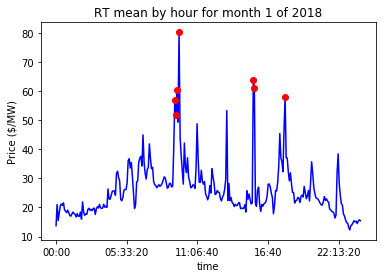

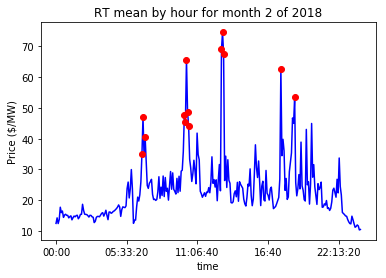

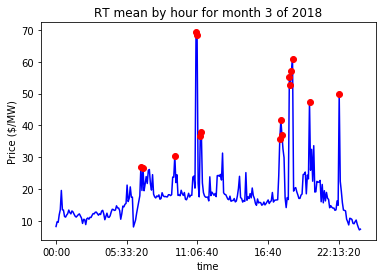

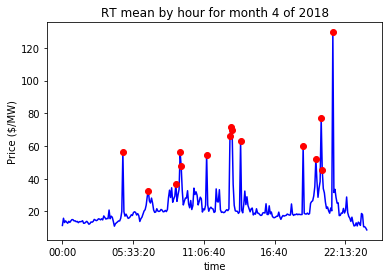

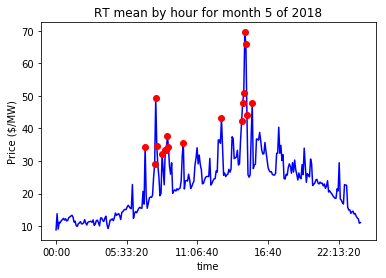

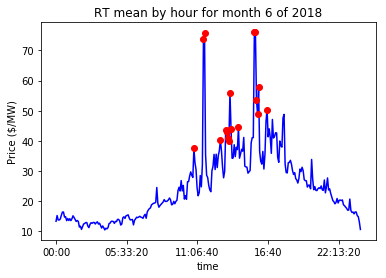

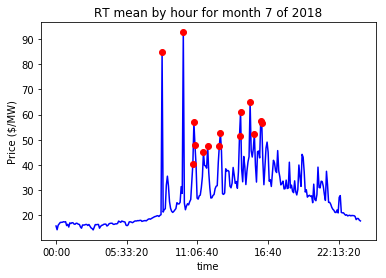

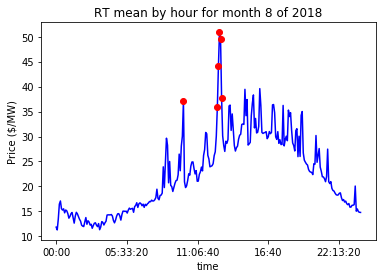

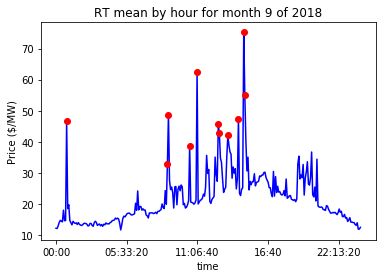

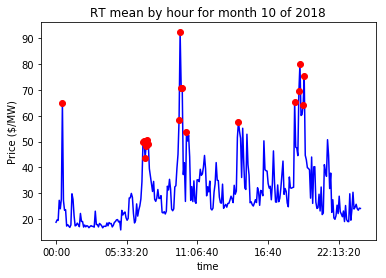

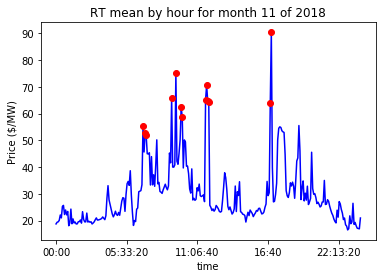

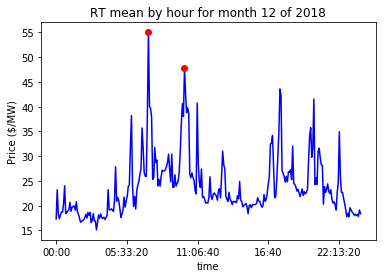

In [93]:
### studying 5-min intervals

monthly_pts = []
for n in range(1,13):
    by_month = RT2018[RT2018['Month']==n]
    data1 = by_month.groupby('Local Time')[['LMP']].mean()
    data1['Local Time'] = data1.index
    
    time = data1.index

    fig, ax1 = plt.subplots()
    
    ax1.plot(time,data1['LMP'],'blue')

    monthly_pts.append(crit_pts(data1))
    
    plt.plot(crit_pts(data1),get_LMP(data1,crit_pts(data1)),'ro')
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [151]:
monthly_pts

[[datetime.time(9, 0)],
 [datetime.time(10, 0), datetime.time(13, 0)],
 [datetime.time(7, 0), datetime.time(11, 0), datetime.time(18, 0)],
 [datetime.time(9, 0), datetime.time(13, 0), datetime.time(20, 0)],
 [datetime.time(7, 0),
  datetime.time(8, 0),
  datetime.time(11, 0),
  datetime.time(13, 0),
  datetime.time(14, 0),
  datetime.time(15, 0)],
 [datetime.time(10, 0),
  datetime.time(11, 0),
  datetime.time(12, 0),
  datetime.time(13, 0),
  datetime.time(14, 0),
  datetime.time(15, 0),
  datetime.time(16, 0),
  datetime.time(17, 0)],
 [datetime.time(8, 0),
  datetime.time(10, 0),
  datetime.time(11, 0),
  datetime.time(12, 0),
  datetime.time(14, 0),
  datetime.time(15, 0),
  datetime.time(16, 0)],
 [datetime.time(12, 0),
  datetime.time(13, 0),
  datetime.time(14, 0),
  datetime.time(15, 0)],
 [datetime.time(12, 0), datetime.time(13, 0), datetime.time(14, 0)],
 [datetime.time(7, 0), datetime.time(9, 0), datetime.time(19, 0)],
 [datetime.time(7, 0), datetime.time(9, 0)],
 [datetime.

In [114]:
def crit_hours(df):
    intervals = df['Local Hour'].values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP'][0:i+1].mean()
        if df['LMP'][i] > 1.5*mean:
            if (df['LMP'][i] - mean) > df['LMP'].mean()/3:
                points.append(time)
        i += 1
    return points
def LMP_hour(df, x):
    i = 0
    LMP = []
    for time in df['Local Hour']:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    array = np.array(LMP)
    return array

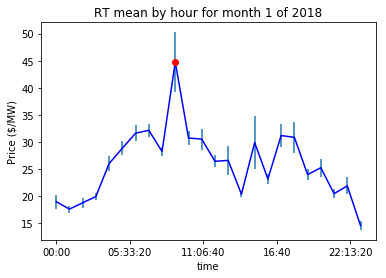

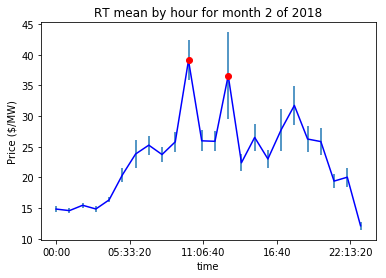

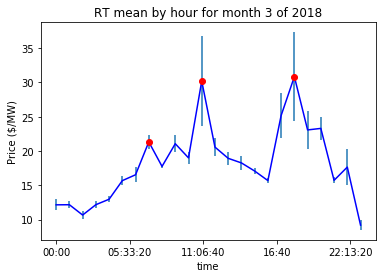

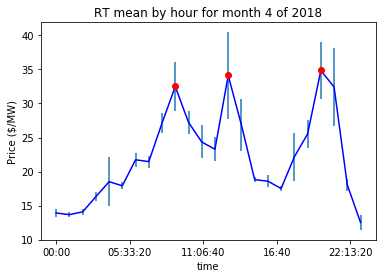

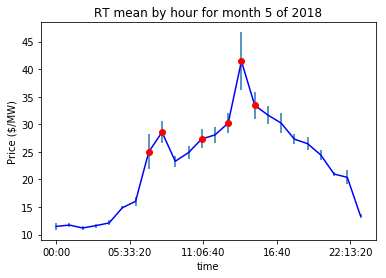

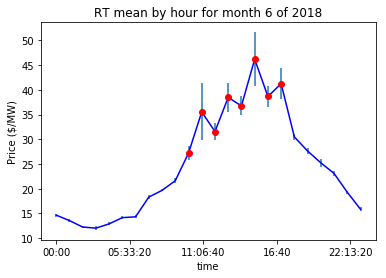

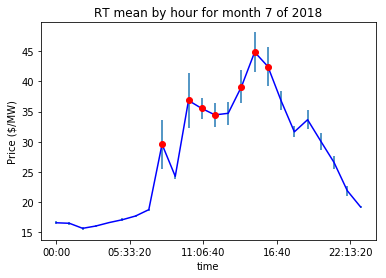

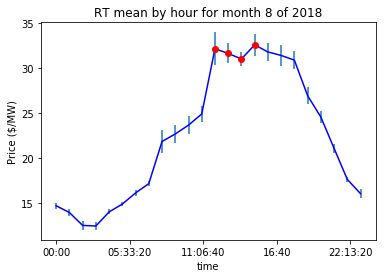

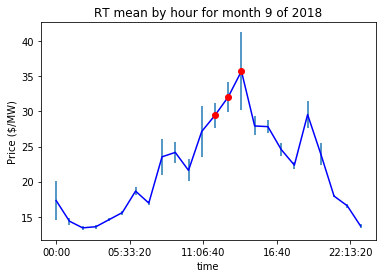

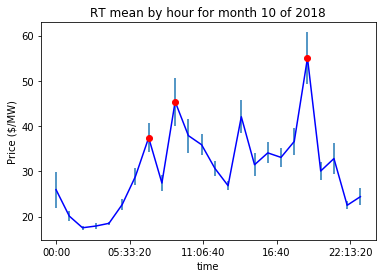

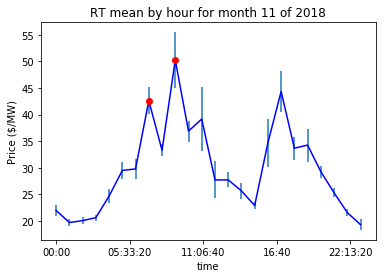

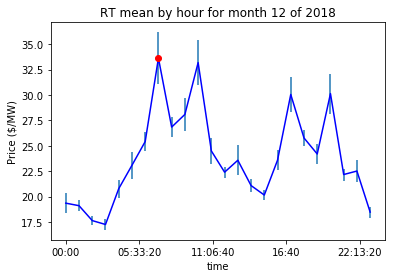

In [95]:
monthly_pts = []

for n in range(1,13):
    by_month = RT2018[RT2018['Month']==n]
    data1 = by_month.groupby('Hour')[['LMP']].mean()
    data1['sem'] = by_month.groupby('Hour')[['LMP']].sem()
    data1['Local Hour'] = data1.index

    time = data1.index

    monthly_pts.append(crit_hours(data1))   
    
    fig, ax1 = plt.subplots()
    ax1.plot(time,data1['LMP'],'blue')
    plt.plot(crit_hours(data1),LMP_hour(data1,crit_hours(data1)),'ro')
    ax1.errorbar(time,data1['LMP'], data1['sem'],
                 fmt='none')
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [96]:
RT_dfs = []
days_31 = []
for n in range(1,32):
    days_31.append(n)
cal_dict = {1:days_31,
            2:days_31[0:28],
            3:days_31,
            4:days_31[0:-1],
            5:days_31,
            6:days_31[0:-1],
            7:days_31,
            8:days_31,
            9:days_31[0:-1],
            10:days_31,
            11:days_31[0:-1],
            12:days_31}
for key in cal_dict.keys():
    for value in cal_dict[key]:
        day_df = RT2018[(RT2018['Month']==key)&(RT2018['Day']==value)]
        RT_dfs.append(day_df.groupby('Hour')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'}))
RT2018_hour = pd.concat(RT_dfs)
RT2018_hour.head()

Interval         LMP
Hour                                     
00:00:00  01/01/2018 00:05:00  116.701657
01:00:00  01/01/2018 01:00:00   28.641704
02:00:00  01/01/2018 02:00:00   50.201946
03:00:00  01/01/2018 03:00:00   28.285259
04:00:00  01/01/2018 04:00:00  122.022561

In [98]:
RT2018_hour.index = RT2018_hour['Interval']
RT2018_hour.head()

Interval         LMP
Interval                                            
01/01/2018 00:05:00  01/01/2018 00:05:00  116.701657
01/01/2018 01:00:00  01/01/2018 01:00:00   28.641704
01/01/2018 02:00:00  01/01/2018 02:00:00   50.201946
01/01/2018 03:00:00  01/01/2018 03:00:00   28.285259
01/01/2018 04:00:00  01/01/2018 04:00:00  122.022561

In [107]:
DART2018 = DA2018_aggloc.join(RT2018_hour,how='right',lsuffix='_DA',rsuffix='_RT')
DART2018.head()

Interval_DA     LMP_DA  Local Date Local Time  \
Interval                                                                     
01/01/2018 00:05:00                  NaN        NaN         NaN        NaN   
01/01/2018 01:00:00  01/01/2018 01:00:00  37.390157  2018-01-01   01:00:00   
01/01/2018 02:00:00  01/01/2018 02:00:00  37.249877  2018-01-01   02:00:00   
01/01/2018 03:00:00  01/01/2018 03:00:00  37.998882  2018-01-01   03:00:00   
01/01/2018 04:00:00  01/01/2018 04:00:00  40.778408  2018-01-01   04:00:00   

                         Hour Weekday  Month  Day          Interval_RT  \
Interval                                                                 
01/01/2018 00:05:00       NaN     NaN    NaN  NaN  01/01/2018 00:05:00   
01/01/2018 01:00:00  01:00:00    True    1.0  1.0  01/01/2018 01:00:00   
01/01/2018 02:00:00  02:00:00    True    1.0  1.0  01/01/2018 02:00:00   
01/01/2018 03:00:00  03:00:00    True    1.0  1.0  01/01/2018 03:00:00   
01/01/2018 04:00:00  04:00:00    True    1.0  1.0  01/01/2018 04:00:00   

                         LMP_RT  
Interval                         
01/01/2018 00:05:00  116.701657  
01/01/2018 01:00:00   28.641704  
01/01/2018 02:00:00   50.201946  
01/01/2018 03:00:00   28.285259  
01/01/2018 04:00:00  122.022561

In [116]:
def critical(df):
    intervals = df['Local Hour'].values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP_RT'][0:i+1].mean()
        if df['LMP_RT'][i] > 1.5*mean:
            if (df['LMP_RT'][i] - mean) > df['LMP_RT'].mean()/3:
                points.append(time)
        i += 1
    x = np.array(points)
    
    i = 0
    LMP = []
    for time in df['Local Hour']:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    y = np.array(LMP)
    
    return [x,y]


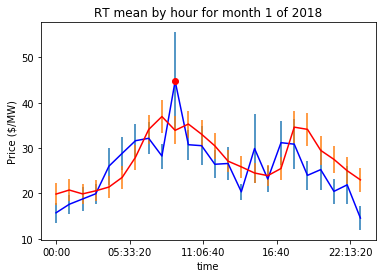

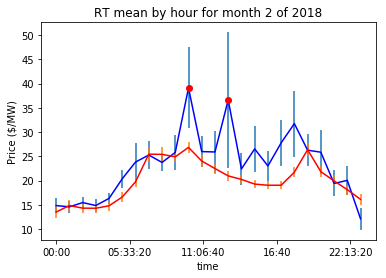

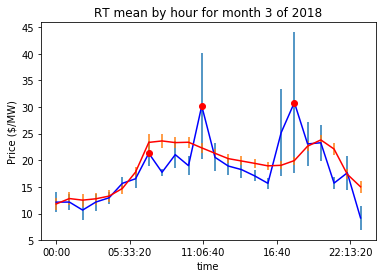

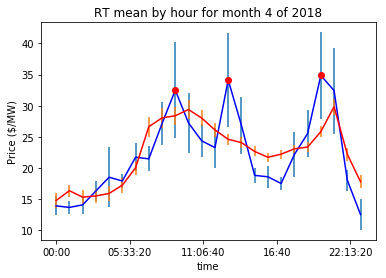

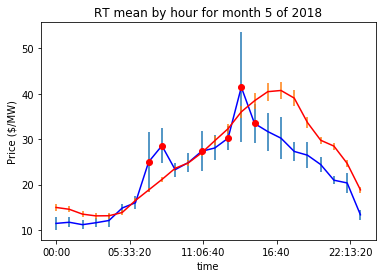

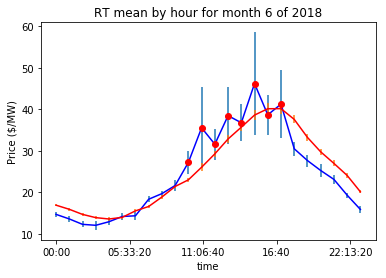

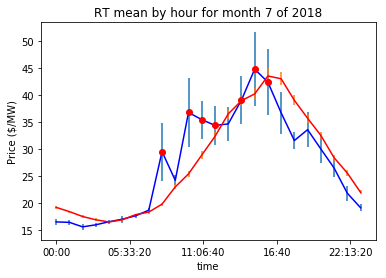

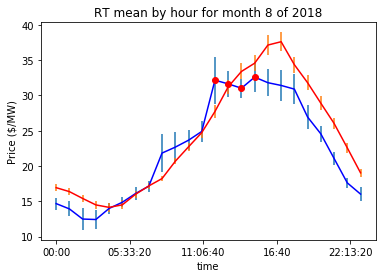

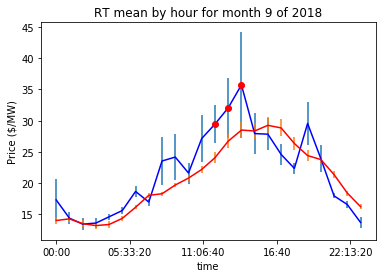

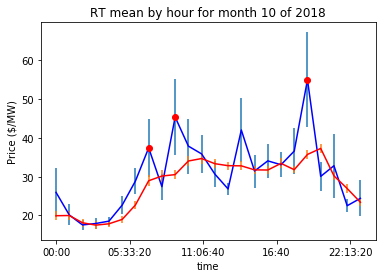

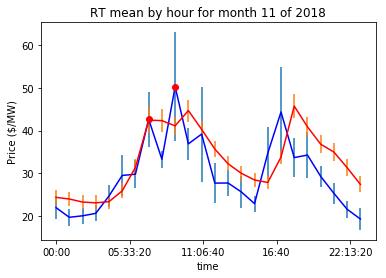

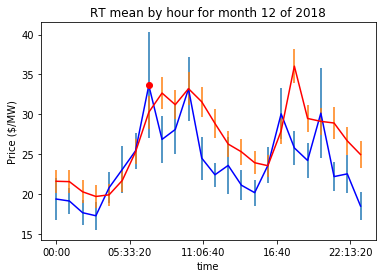

In [118]:
for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]
    data1 = by_month.groupby('Hour')[['LMP_RT']].mean()
    data1['sem'] = by_month.groupby('Hour')[['LMP_RT']].sem()
    data1['Local Hour'] = data1.index
    time = data1.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time,data1['LMP_RT'],'blue')
    ax1.errorbar(time,data1['LMP_RT'], data1['sem'],
                 fmt='none')
    
    data2 = by_month.groupby('Hour')[['LMP_DA']].mean()
    data2['sem'] = by_month.groupby('Hour')[['LMP_DA']].sem()
    data2['Local Hour'] = data2.index
    time = data2.index
    
    ax1.plot(time,data2['LMP_DA'],'red')
    ax1.errorbar(time,data2['LMP_DA'], data2['sem'],
                 fmt='none')
    
    plt.plot(critical(data1)[0],critical(data1)[1],'ro')

    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [129]:
def critical2(df):
    intervals = df['Local Hour'].values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP_RT'][0:i+1].mean()
        if df['LMP_RT'][i] > 1.5*mean:
            if (df['LMP_RT'][i] - mean) > df['LMP_RT'].mean()/3:
                if df['LMP_RT'][i] > 1.1*df['LMP_DA'][i]:
                    points.append(time)
        elif df['LMP_RT'][i] > 1.3*df['LMP_DA'][i]:
            points.append(time)
        i += 1
    x = np.array(points)
    
    i = 0
    LMP = []
    for time in df['Local Hour']:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    y = np.array(LMP)
    
    return [x,y]

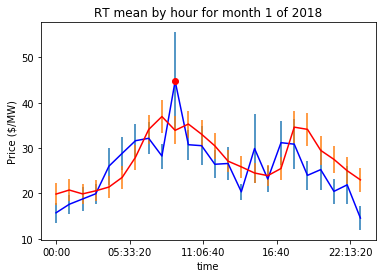

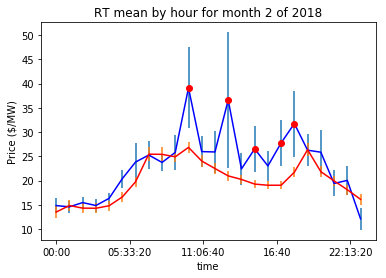

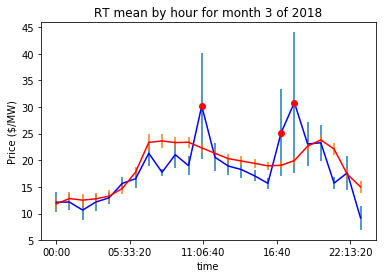

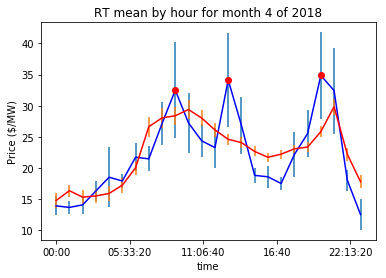

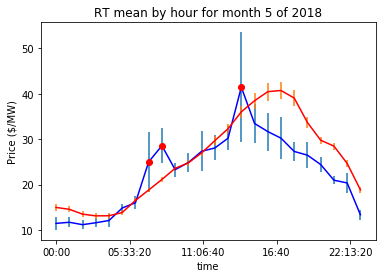

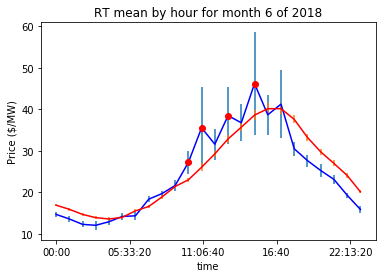

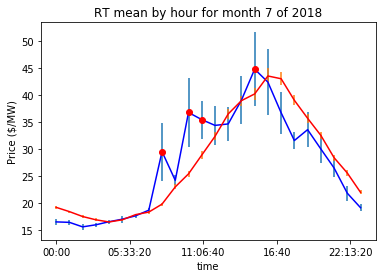

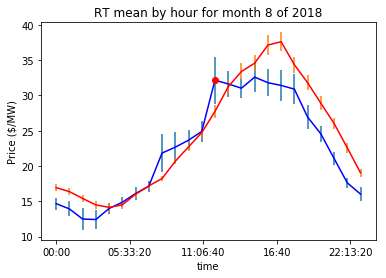

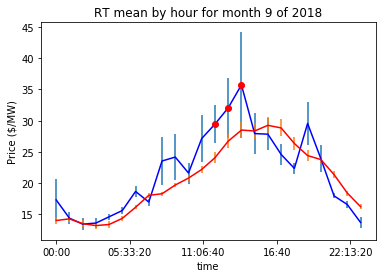

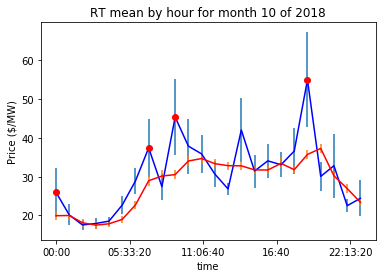

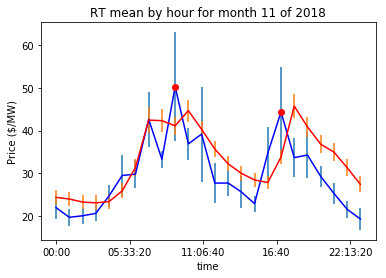

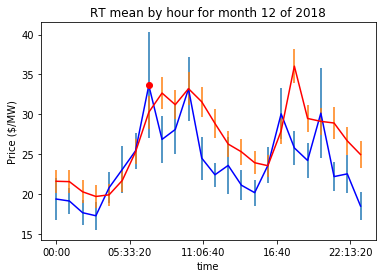

In [131]:
crit_hours = []

for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]
    
    data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    data['sem_RT'] = by_month.groupby('Hour')[['LMP_RT']].sem()
    data['sem_DA'] = by_month.groupby('Hour')[['LMP_DA']].sem()    
    data['Local Hour'] = data.index
    time = data1.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, data['LMP_RT'], 'blue')
    ax1.errorbar(time, data['LMP_RT'], data['sem_RT'], fmt='none')
    
    ax1.plot(time, data['LMP_DA'], 'red')
    ax1.errorbar(time, data['LMP_DA'], data['sem_DA'], fmt='none')
    
    plt.plot(critical2(data)[0],critical2(data)[1],'ro')

    crit_hours.append(critical2(data)[0])
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [160]:
hours_list = []
for list_of_hours in crit_hours:
    for hour in list_of_hours:
        hours_list.append(hour)
hours_array = np.array(hours_list)
hours_df = pd.DataFrame({'Hour':hours_array})
hours_df.groupby('Hour')[['Hour']].count().sort_values('Hour',ascending=False).head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: 'Hour' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  import sys


Hour
Hour          
09:00:00     4
13:00:00     4
07:00:00     3
10:00:00     3
11:00:00     3

In [175]:
def ssr_split2(df, s):
    if df.shape[0]>8:
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df[s][0:i+1].values.mean()
                y_avg2 = df[s][i:df.shape[0]].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum() + ((df[s][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df[s].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        smallest = df.iloc[0:smallest_x+1]
        largest = df.iloc[smallest_x+1:]
        if smallest.shape[0] > largest.shape[0]:
            temp = smallest
            smallest = largest
            largest = temp
        return [smallest] + [ssr_split2(largest, s)]
    else:
        return [df]

In [249]:
n = 2.0
split = ssr_split2(DART2018[DART2018['Month']==n].groupby('Hour')[['LMP_RT','LMP_DA']].mean(),'LMP_RT')

In [243]:
def clusters(nested):
    concat = []
    dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0]]
    for df in dfs:
        means = np.empty(df.shape[0])
        means.fill(df['LMP_RT'].mean())
        df['Means'] = means
        concat.append(df)

    unnested = pd.concat(concat)
    unnested['Time'] = unnested.index
    unnested = unnested.sort_values('Time')
    return unnested

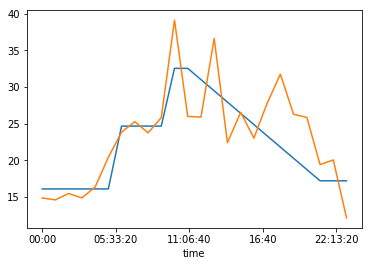

In [250]:
cl = clusters(split)
plt.plot(cl.index,cl['Means'])
jan = DART2018[DART2018['Month']==n]
data = jan.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
plt.plot(data.index,data['LMP_RT'])

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


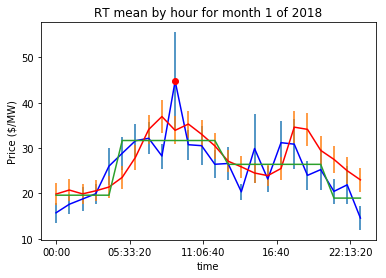

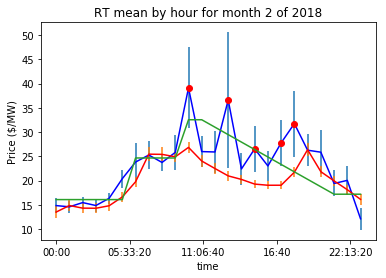

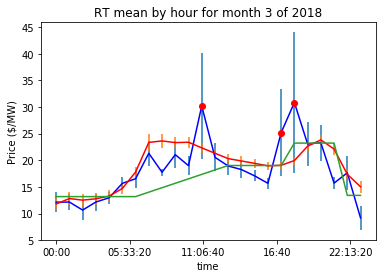

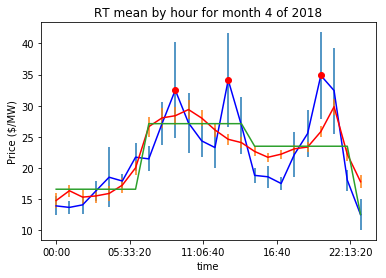

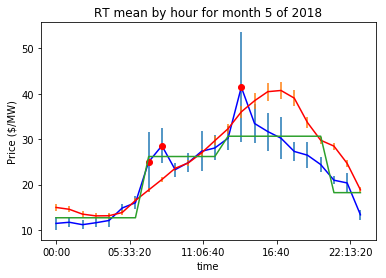

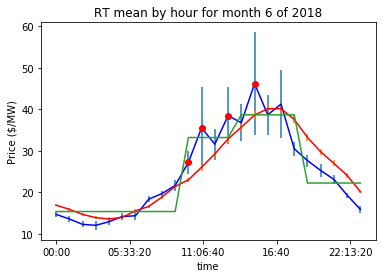

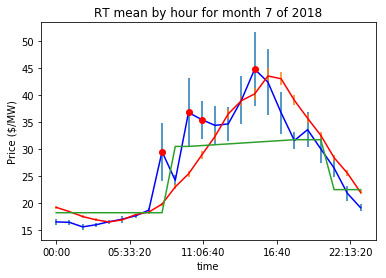

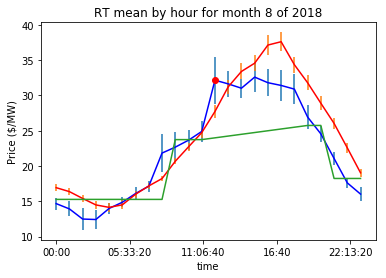

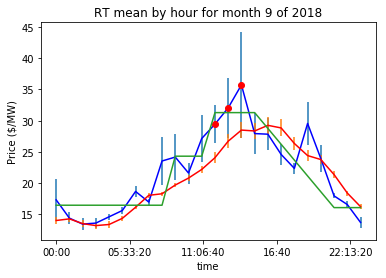

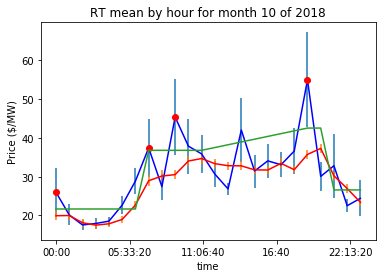

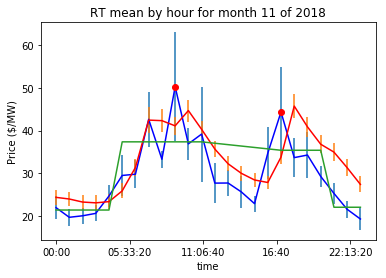

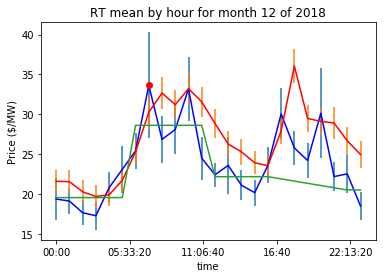

In [248]:
for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]
    
    data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    data['sem_RT'] = by_month.groupby('Hour')[['LMP_RT']].sem()
    data['sem_DA'] = by_month.groupby('Hour')[['LMP_DA']].sem()    
    data['Local Hour'] = data.index
    time = data1.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, data['LMP_RT'], 'blue')
    ax1.errorbar(time, data['LMP_RT'], data['sem_RT'], fmt='none')
    
    ax1.plot(time, data['LMP_DA'], 'red')
    ax1.errorbar(time, data['LMP_DA'], data['sem_DA'], fmt='none')
    
    plt.plot(critical2(data)[0],critical2(data)[1],'ro')

    cl = clusters(ssr_split2(data, 'LMP_RT'))
    plt.plot(cl.index,cl['Means'])
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [251]:
def ssr_split3(df, s):
    if df.shape[0]>8:
        smallest_y = 0
        smallest_x = 0
        for i in range(0, df.shape[0]):
            try:
                y_avg1 = df[s][0:i+1].values.mean()
                y_avg2 = df[s][i:df.shape[0]].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum() + ((df[s][i:df.shape[0]].values - y_avg2)**2).sum()
                if i == 0:
                    smallest_y = ssr
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
            except:
                y_avg1 = df[s].values.mean()
                ssr = ((df[s][0:i+1].values - y_avg1)**2).sum()
                if ssr < smallest_y:
                    smallest_y = ssr
                    smallest_x = i
        smallest = df.iloc[0:smallest_x+1]
        largest = df.iloc[smallest_x+1:]
        if smallest.shape[0] > largest.shape[0]:
            temp = smallest
            smallest = largest
            largest = temp
        concat = [smallest] + [ssr_split2(largest, s)]
        return concat
    else:
        return df

2

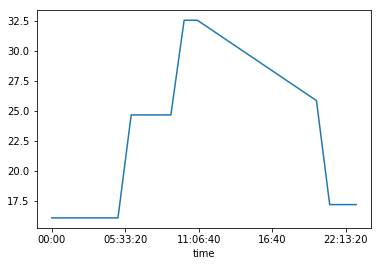

In [269]:
n = 2.0
split = ssr_split2(DART2018[DART2018['Month']==n].groupby('Hour')[['LMP_RT','LMP_DA']].mean(),'LMP_RT')
cl = clusters2(split)
plt.plot(cl.index,cl['Means'])
len(split[1])

In [294]:
def clusters2(nested):
    concat = []
    try:
        dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0],nested[1][1][1][1][0],nested[1][1][1][1][1][0]]
    except:
        try:
            dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0],nested[1][1][1][1][0]]
        except:
            try:
                dfs = [nested[0],nested[1][0],nested[1][1][0],nested[1][1][1][0]]
            except:
                try:
                    dfs = [nested[0],nested[1][0],nested[1][1][0]]
                except:
                    return None
    for df in dfs:
        means = np.empty(df.shape[0])
        means.fill(df['LMP_RT'].mean())
        df['Means'] = means
        concat.append(df)

    unnested = pd.concat(concat)
    unnested['Time'] = unnested.index
    unnested = unnested.sort_values('Time')
    return unnested

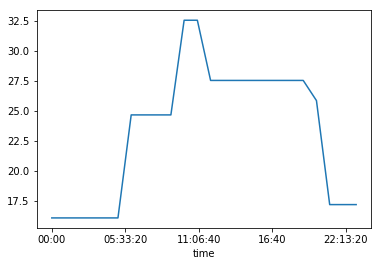

In [271]:
n = 2.0
split = ssr_split3(DART2018[DART2018['Month']==n].groupby('Hour')[['LMP_RT','LMP_DA']].mean(),'LMP_RT')
cl = clusters2(split)
plt.plot(cl.index,cl['Means'])


C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


421.3545063913462


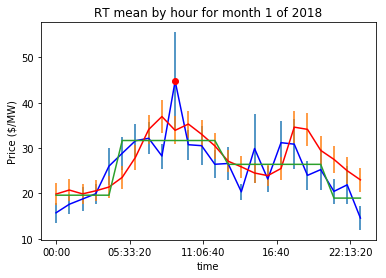

304.3583592029963


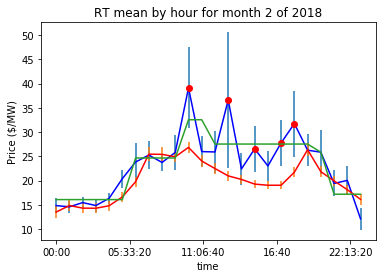

327.25117583763927


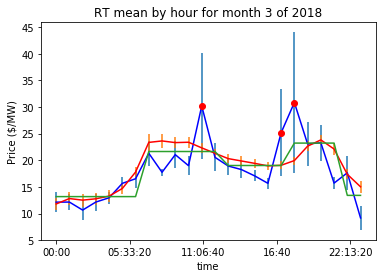

513.2456481924607


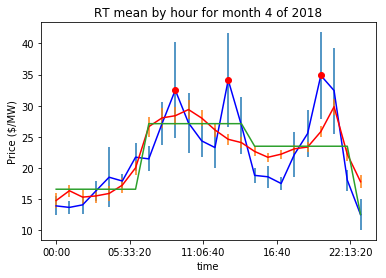

273.02525177377083


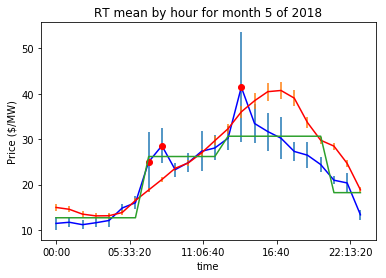

394.19210541611704


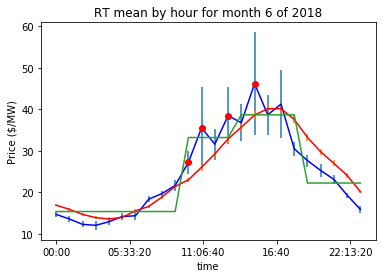

362.6383434823858


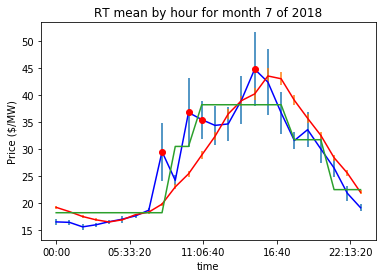

87.99999523833307


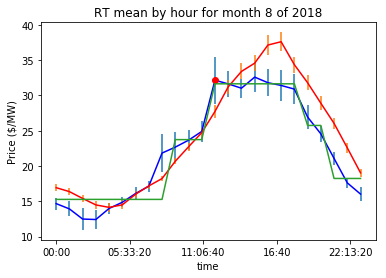

176.85808251972193


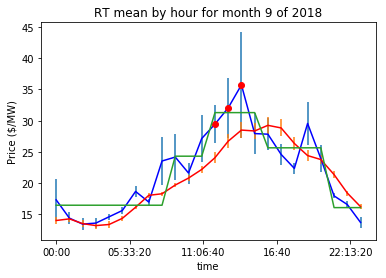

791.1134896833852


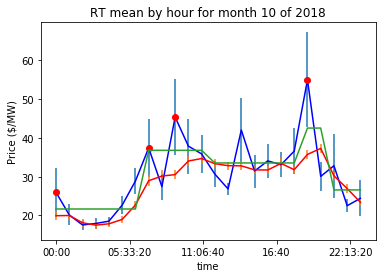

565.8784627750489


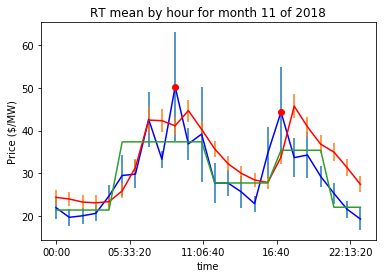

167.4839255513077


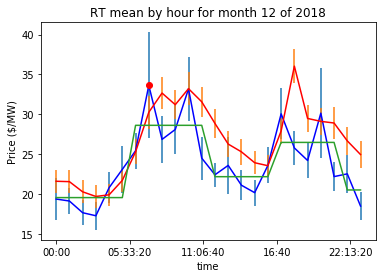

In [277]:
for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]
    
    data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    data['sem_RT'] = by_month.groupby('Hour')[['LMP_RT']].sem()
    data['sem_DA'] = by_month.groupby('Hour')[['LMP_DA']].sem()    
    data['Local Hour'] = data.index
    time = data.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, data['LMP_RT'], 'blue')
    ax1.errorbar(time, data['LMP_RT'], data['sem_RT'], fmt='none')
    
    ax1.plot(time, data['LMP_DA'], 'red')
    ax1.errorbar(time, data['LMP_DA'], data['sem_DA'], fmt='none')
    
    plt.plot(critical2(data)[0],critical2(data)[1],'ro')

    cl = clusters2(ssr_split3(data, 'LMP_RT'))
    plt.plot(cl.index,cl['Means'])
    
    print(ssr(cl['Means'],data['LMP_RT']))
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [276]:
def ssr(prediction, test):
    return ((prediction - test)**2).sum()

In [286]:
data = DART2018[DART2018['Month']==1.0]

In [287]:
train, test = train_test_split(data, test_size=0.33)

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


5.661855854509802


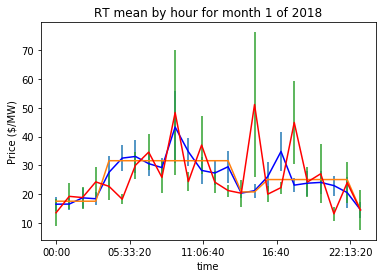

5.358215487009512


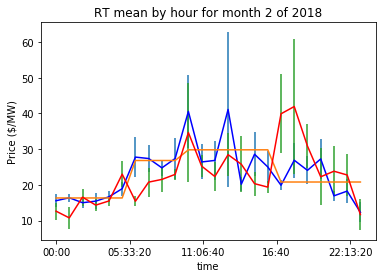

3.8122532333041046


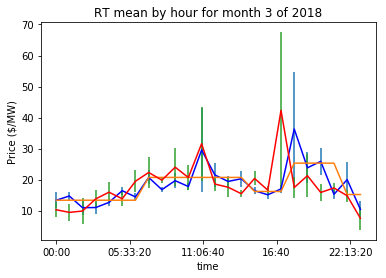

2.585434204141021


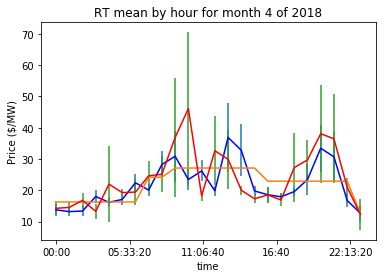

4.39326934935967


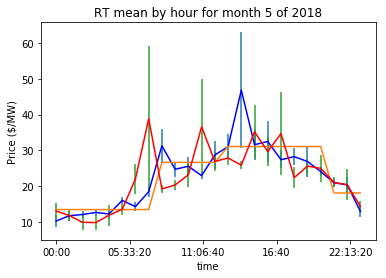

9.460216081524608


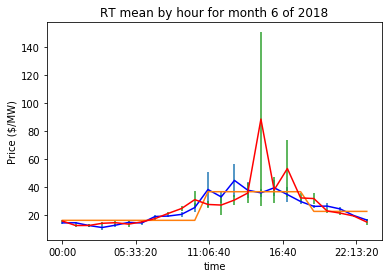

2.9408484686009393


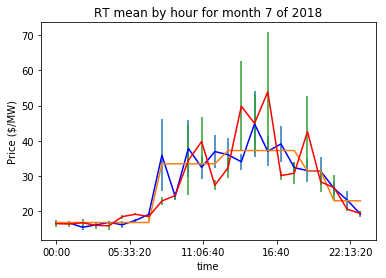

3.1881408905273334


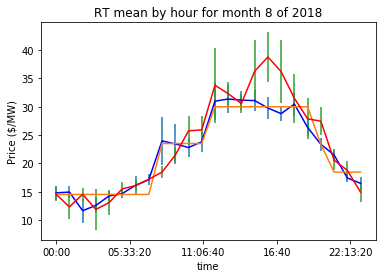

4.671790206498134


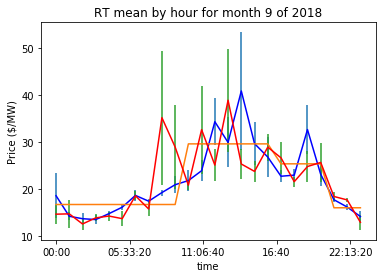

4.457044420471592


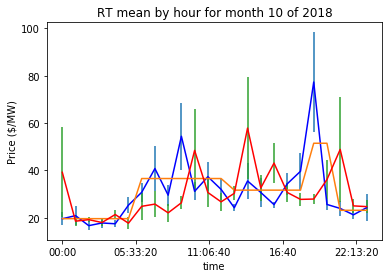

4.086705160318161


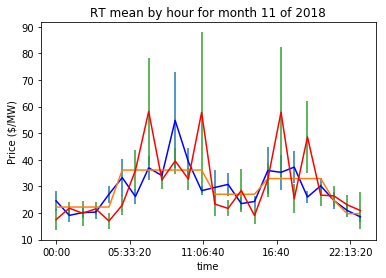

4.094788194377723


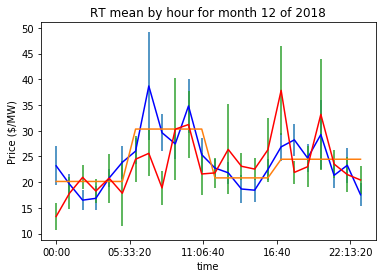

In [293]:
for n in range(1,13):
    by_month = DART2018[DART2018['Month']==float(n)]

    total_data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    total_cl = clusters2(ssr_split3(total_data, 'LMP_RT'))
    
    train, test = train_test_split(by_month, test_size=0.33)
    
    train_data = train.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    train_data['sem_RT'] = train.groupby('Hour')[['LMP_RT']].sem()
    train_data['sem_DA'] = train.groupby('Hour')[['LMP_DA']].sem()    
    train_data['Local Hour'] = train_data.index
    time = train_data.index
    
    fig, ax1 = plt.subplots()
    ax1.plot(time, train_data['LMP_RT'], 'blue')
    ax1.errorbar(time, train_data['LMP_RT'], train_data['sem_RT'], fmt='none')
    
    #plt.plot(critical2(data)[0],critical2(data)[1],'ro')

    cl = clusters2(ssr_split3(train_data, 'LMP_RT'))
    plt.plot(cl.index,cl['Means'])
    
    test_data = test.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
    test_data['sem_RT'] = test.groupby('Hour')[['LMP_RT']].sem()
    test_data['Local Hour'] = test_data.index
    time = test_data.index
    
    ax1.plot(time, test_data['LMP_RT'], 'red')
    ax1.errorbar(time, test_data['LMP_RT'], test_data['sem_RT'], fmt='none')
    
    print(ssr(cl['Means'],test_data['LMP_RT'])/ssr(total_cl['Means'],total_data['LMP_RT']))
    
    plt.ylabel('Price ($/MW)')
    plt.title('RT mean by hour for month {} of 2018'.format(n))
    plt.show()

In [295]:
def experiment(n):
    exp_array = np.empty(n)
    for i in range(n):
        year_ssr = []
        for j in range(1,13):
            by_month = DART2018[DART2018['Month']==float(j)]

            total_data = by_month.groupby('Hour')[['LMP_RT','LMP_DA']].mean()
            total_cl = clusters2(ssr_split3(total_data, 'LMP_RT'))

            train, test = train_test_split(by_month, test_size=0.33)

            train_data = train.groupby('Hour')[['LMP_RT','LMP_DA']].mean() 

            cl = clusters2(ssr_split3(train_data, 'LMP_RT'))

            test_data = test.groupby('Hour')[['LMP_RT','LMP_DA']].mean()

            year_ssr.append(ssr(cl['Means'],test_data['LMP_RT'])/ssr(total_cl['Means'],total_data['LMP_RT']))
        exp_array[i] = sum(year_ssr)/len(year_ssr)
    return exp_array

In [297]:
array = experiment(10)
array

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


array([3.42176604, 3.09852643, 4.70441984, 4.01314651, 3.59260455,
       4.47988616, 4.53775309, 4.2736671 , 3.37432702, 5.16037222])

In [298]:
array.mean()

4.06564689636665